### Import Libraries

In [11]:
import pandas as pd
import numpy as np
import re

## web Scraping

In [3]:
import time
import csv
import json
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd

class BanggoodScraper:
    def __init__(self, headless=False):
        # Setup Chrome options
        chrome_options = Options()
        
        if headless:
            chrome_options.add_argument('--headless=new')
        
        # Anti-detection measures
        chrome_options.add_argument('--disable-blink-features=AutomationControlled')
        chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
        chrome_options.add_experimental_option('useAutomationExtension', False)
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--window-size=1920,1080')
        chrome_options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36')
        
        self.driver = webdriver.Chrome(options=chrome_options)
        
        # Execute script to hide webdriver property
        self.driver.execute_cdp_cmd('Network.setUserAgentOverride', {
            "userAgent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'
        })
        self.driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
        
        self.all_products = []
        
    def scroll_page(self):
        """Scroll to load all products"""
        last_height = self.driver.execute_script("return document.body.scrollHeight")
        
        for i in range(5):  # Scroll 5 times
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            
            new_height = self.driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height
            print(f"  Scrolling... ({i+1}/5)")
    
    def extract_product_data(self, product_element):
        """Extract data from a single product element"""
        try:
            product_data = {}
            
            # Product Name and URL
            try:
                title = product_element.find_element(By.CSS_SELECTOR, 'a.title')
                product_data['name'] = title.get_attribute('title').strip()
                product_data['url'] = title.get_attribute('href')
            except NoSuchElementException:
                try:
                    # Alternative selector
                    title = product_element.find_element(By.CSS_SELECTOR, '.p-wrap a[href*="banggood.com"]')
                    product_data['name'] = title.get_attribute('title') or title.text.strip()
                    product_data['url'] = title.get_attribute('href')
                except:
                    product_data['name'] = 'N/A'
                    product_data['url'] = 'N/A'
            
            # Price
            try:
                price = product_element.find_element(By.CSS_SELECTOR, 'span.price')
                product_data['price'] = price.text.strip()
            except NoSuchElementException:
                try:
                    price = product_element.find_element(By.CSS_SELECTOR, '.price-box .price')
                    product_data['price'] = price.text.strip()
                except:
                    product_data['price'] = 'N/A'
            
            # Rating
            try:
                rating = product_element.find_element(By.CSS_SELECTOR, 'span.review-text')
                product_data['rating'] = rating.text.strip()
            except NoSuchElementException:
                try:
                    rating = product_element.find_element(By.CSS_SELECTOR, '.review-text')
                    product_data['rating'] = rating.text.strip()
                except:
                    product_data['rating'] = 'N/A'
            
            # Reviews Count
            try:
                reviews = product_element.find_element(By.CSS_SELECTOR, 'a.review')
                reviews_text = reviews.text.strip()
                product_data['reviews'] = reviews_text.split()[0] if reviews_text else 'N/A'
            except NoSuchElementException:
                try:
                    reviews = product_element.find_element(By.CSS_SELECTOR, '.review')
                    reviews_text = reviews.text.strip()
                    product_data['reviews'] = reviews_text.split()[0] if reviews_text else '0'
                except:
                    product_data['reviews'] = '0'
            
            # Product ID
            try:
                product_data['product_id'] = product_element.get_attribute('data-product-id')
            except:
                product_data['product_id'] = 'N/A'
            
            return product_data
            
        except Exception as e:
            print(f"  Error extracting product: {e}")
            return None
    
    def get_category_id(self, category_url):
        """Extract category ID from URL"""
        try:
            if 'ca-' in category_url:
                cat_id = category_url.split('ca-')[1].split('.')[0]
            elif 'c-' in category_url:
                cat_id = category_url.split('c-')[1].split('.')[0]
            else:
                cat_id = None
            return cat_id
        except:
            return None
    
    def scrape_category(self, category_url, category_name, max_pages=3):
        """Scrape products from a category"""
        print(f"\n{'='*60}")
        print(f"Scraping Category: {category_name}")
        print(f"{'='*60}")
        
        cat_id = self.get_category_id(category_url)
        
        for page in range(1, max_pages + 1):
            try:
                # Construct page URL with correct parameters
                if page == 1:
                    url = category_url
                else:
                    if cat_id:
                        # Use the correct pagination format
                        base_url = category_url.split('?')[0]
                        url = f"{base_url}?cat_id={cat_id}&page={page}&direct=0&sort=1&sortType=desc"
                    else:
                        separator = '&' if '?' in category_url else '?'
                        url = f"{category_url}{separator}page={page}"
                
                print(f"\nFetching Page {page}: {url}")
                self.driver.get(url)
                
                # Wait for page load
                time.sleep(5)
                
                # Wait for products to load - try multiple selectors
                try:
                    WebDriverWait(self.driver, 20).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, 'li[data-product-id]'))
                    )
                    print("  ✓ Products loaded successfully")
                except TimeoutException:
                    print("  ⚠ Timeout with first selector, trying alternatives...")
                    try:
                        WebDriverWait(self.driver, 10).until(
                            EC.presence_of_element_located((By.CSS_SELECTOR, '.p-wrap'))
                        )
                        print("  ✓ Products loaded with alternative selector")
                    except TimeoutException:
                        print("  ✗ Could not find products on this page")
                        # Save page source for debugging
                        with open(f'debug_page_{category_name}_page{page}.html', 'w', encoding='utf-8') as f:
                            f.write(self.driver.page_source)
                        print(f"  Saved debug HTML to debug_page_{category_name}_page{page}.html")
                        continue
                
                # Scroll to load more products
                self.scroll_page()
                time.sleep(3)
                
                # Find all product elements - try multiple selectors
                products = self.driver.find_elements(By.CSS_SELECTOR, 'li[data-product-id]')
                
                if not products:
                    print("  No products with data-product-id, trying alternative selectors...")
                    products = self.driver.find_elements(By.CSS_SELECTOR, '.p-wrap')
                
                print(f"  Found {len(products)} products on page {page}")
                
                if len(products) == 0:
                    print("  ⚠ No products found, skipping page")
                    continue
                
                # Extract data from each product
                extracted_count = 0
                for idx, product in enumerate(products, 1):
                    product_data = self.extract_product_data(product)
                    if product_data and product_data['name'] != 'N/A':
                        product_data['category'] = category_name
                        product_data['page'] = page
                        self.all_products.append(product_data)
                        extracted_count += 1
                        if idx <= 5:  # Show first 5 products
                            print(f"  [{idx}] {product_data['name'][:60]}... - {product_data['price']}")
                
                print(f"  ✓ Successfully extracted {extracted_count} products from page {page}")
                
                # Respectful delay between pages
                time.sleep(4)
                
            except Exception as e:
                print(f"  ✗ Error scraping page {page}: {e}")
                continue
    
    def save_to_csv(self, filename='banggood_products.csv'):
        """Save scraped data to CSV"""
        if not self.all_products:
            print("\n✗ No products to save!")
            return
        
        df = pd.DataFrame(self.all_products)
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"\n✓ Data saved to {filename}")
        print(f"✓ Total products scraped: {len(self.all_products)}")
    
    def save_to_json(self, filename='banggood_products.json'):
        """Save scraped data to JSON"""
        if not self.all_products:
            print("\n✗ No products to save!")
            return
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(self.all_products, f, indent=2, ensure_ascii=False)
        print(f"✓ Data saved to {filename}")
    
    def close(self):
        """Close the browser"""
        self.driver.quit()

def main():
    # Define 5 categories to scrape with CORRECTED URLs
    categories = {
        'RC Helicopter': 'https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?bid=2107010101&from=nav',
        'RC Cars': 'https://www.banggood.com/Wholesale-RC-Cars-ca-7001.html',
        'Smart Watch': 'https://www.banggood.com/Wholesale-Smart-Watch-ca-2210.html?bid=2107060201&from=nav',
        'LED Lights': 'https://www.banggood.com/Wholesale-Ceiling-Lights-and-Chandeliers-ca-14057.html?bid=2107100101&from=nav',
        'Power Tools': 'https://www.banggood.com/Wholesale-Power-Supply-Module-ca-2288.html?bid=2107050303&from=nav'
    }
    
    print("\n" + "="*60)
    print("BANGGOOD WEB SCRAPER")
    print("="*60)
    print("This scraper will run with browser visible (not headless)")
    print("You can watch the progress in the browser window")
    print("="*60)
    
    # Initialize scraper (headless=False to see browser)
    scraper = BanggoodScraper(headless=False)
    
    try:
        # Scrape each category
        for category_name, category_url in categories.items():
            scraper.scrape_category(category_url, category_name, max_pages=3)
        
        # Save results
        if scraper.all_products:
            scraper.save_to_csv()
            scraper.save_to_json()
            
            # Display summary
            print("\n" + "="*60)
            print("SCRAPING SUMMARY")
            print("="*60)
            
            df = pd.DataFrame(scraper.all_products)
            print(f"\n✓ Total Products: {len(df)}")
            print(f"\n✓ Products per Category:")
            print(df['category'].value_counts())
            
            print(f"\n✓ Sample Data (first 5 products):")
            print(df[['name', 'price', 'rating', 'reviews', 'category']].head().to_string())
        else:
            print("\n✗ No products were scraped. Check the debug HTML files for issues.")
        
    except Exception as e:
        print(f"\n✗ Error in main execution: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        input("\nPress Enter to close the browser...")
        scraper.close()
        print("\n✓ Scraper closed successfully")

if __name__ == "__main__":
    main()


BANGGOOD WEB SCRAPER
This scraper will run with browser visible (not headless)
You can watch the progress in the browser window

Scraping Category: RC Helicopter

Fetching Page 1: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?bid=2107010101&from=nav
  ✓ Products loaded successfully
  Found 2 products on page 1
  [1] Mini Gesture Sensing Levitation Flying Led Light Crystal Bal... - £14.76
  [2] Gesture Sensing Smart Levitation Led Light Altitude Hold Tra... - £8.54
  ✓ Successfully extracted 2 products from page 1

Fetching Page 2: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=2&direct=0&sort=1&sortType=desc
  ⚠ Timeout with first selector, trying alternatives...
  ✗ Could not find products on this page
  Saved debug HTML to debug_page_RC Helicopter_page2.html

Fetching Page 3: https://www.banggood.com/Wholesale-RC-Helicopter-ca-7003.html?cat_id=7003&page=3&direct=0&sort=1&sortType=desc
  ⚠ Timeout with first selector, trying alternative

# Data Cleaning & Transformation

In [6]:
#  LOAD DATA
df = pd.read_csv("banggood_products.csv")
print(f"Original data shape: {df.shape}")
df.head()

Original data shape: (486, 8)


,name,url,price,rating,reviews,product_id,category,page
0,Mini Gesture Sensing Levitation Flying Led Lig...,https://www.banggood.com/Mini-Gesture-Sensing-...,£14.76,5.00,5,1978021,RC Helicopter,1
1,Gesture Sensing Smart Levitation Led Light Alt...,https://www.banggood.com/Gesture-Sensing-Smart...,£8.54,5.00,6,1978025,RC Helicopter,1
2,JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...,https://www.banggood.com/JIABAILE-4301-or-02-o...,£18.34,4.82,254,2017095,RC Cars,1
3,MJX HYPER GO 16208 16209 1/16 Brushless High S...,https://www.banggood.com/MJX-HYPER-GO-16208-16...,£73.07,4.85,700,1967165,RC Cars,1
4,Orlandoo Hunter OH32X02 1/32 RWD Mini Truck RC...,https://www.banggood.com/Orlandoo-Hunter-OH32X...,£58.77,4.83,42,1989380,RC Cars,1


In [9]:


# Step 1: Load the scraped data into a pandas DataFrame
print("="*60)
print("STEP 1: LOADING DATA")
print("="*60)

# Load the CSV file (change filename if needed)
df = pd.read_csv('banggood_products.csv')

# Display basic information
print(f"\n✓ Data loaded successfully!")
print(f"✓ Total rows: {len(df)}")
print(f"✓ Total columns: {len(df.columns)}")

# Show column names
print(f"\n✓ Column names:")
print(df.columns.tolist())

# Show first 5 rows
print(f"\n✓ First 5 rows of data:")
print(df.head())

# Show data types
print(f"\n✓ Data types:")
print(df.dtypes)

# Show basic statistics
print(f"\n✓ Basic info:")
print(df.info())

# Check for missing values
print(f"\n✓ Missing values in each column:")
print(df.isnull().sum())

print("\n" + "="*60)
print("STEP 1 COMPLETED!")
print("="*60)

STEP 1: LOADING DATA

✓ Data loaded successfully!
✓ Total rows: 486
✓ Total columns: 8

✓ Column names:
['name', 'url', 'price', 'rating', 'reviews', 'product_id', 'category', 'page']

✓ First 5 rows of data:
                                                name  \
0  Mini Gesture Sensing Levitation Flying Led Lig...   
1  Gesture Sensing Smart Levitation Led Light Alt...   
2  JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...   
3  MJX HYPER GO 16208 16209 1/16 Brushless High S...   
4  Orlandoo Hunter OH32X02 1/32 RWD Mini Truck RC...   

                                                 url   price  rating  reviews  \
0  https://www.banggood.com/Mini-Gesture-Sensing-...  £14.76    5.00        5   
1  https://www.banggood.com/Gesture-Sensing-Smart...   £8.54    5.00        6   
2  https://www.banggood.com/JIABAILE-4301-or-02-o...  £18.34    4.82      254   
3  https://www.banggood.com/MJX-HYPER-GO-16208-16...  £73.07    4.85      700   
4  https://www.banggood.com/Orlandoo-Hunter-OH32X

## Clean Price Column

In [ ]:
print("="*60)
print("STEP 2: CLEANING PRICE DATA")
print("="*60)

# Show original price data
print("\n📌 Original price column (first 10 rows):")
print(df['price'].head(10))

# Function to extract numeric price from string
def extract_price(price_str):
    """
    Extract numeric price from strings like:
    '£14.76', 'US$7.99', '$50.00'
    """
    # Check if value is missing
    if pd.isna(price_str) or price_str == 'N/A':
        return np.nan
    
    # Remove all non-numeric characters except decimal point
    # This removes: £, $, US, etc.
    price_clean = re.sub(r'[^\d.]', '', str(price_str))
    
    # Convert to float
    try:
        return float(price_clean)
    except:
        return np.nan

# Apply the function to create new column
df['price_numeric'] = df['price'].apply(extract_price)

print("\n✓ Created 'price_numeric' column")
print("\n📌 Cleaned price (first 10 rows):")
print(df[['price', 'price_numeric']].head(10))

# Extract currency symbol
def extract_currency(price_str):
    """
    Extract currency symbol from price string
    """
    if pd.isna(price_str) or price_str == 'N/A':
        return 'Unknown'
    
    # Find currency symbol at the start
    match = re.match(r'([£$€¥₹]+|US\$)', str(price_str))
    return match.group(1) if match else 'Unknown'

# Apply function to create currency column
df['currency'] = df['price'].apply(extract_currency)

print("\n✓ Created 'currency' column")
print("\n📌 Price with currency (first 10 rows):")
print(df[['price', 'price_numeric', 'currency']].head(10))

# Show statistics
print("\n📊 Price Statistics:")
print(f"   Mean Price: {df['price_numeric'].mean():.2f}")
print(f"   Median Price: {df['price_numeric'].median():.2f}")
print(f"   Min Price: {df['price_numeric'].min():.2f}")
print(f"   Max Price: {df['price_numeric'].max():.2f}")
print(f"   Missing Prices: {df['price_numeric'].isnull().sum()}")

print("\n" + "="*60)
print("STEP 2 COMPLETED!")
print("="*60)

STEP 2: CLEANING PRICE DATA

📌 Original price column (first 10 rows):
0    £14.76
1     £8.54
2    £18.34
3    £73.07
4    £58.77
5     £5.67
6    £77.73
7     £2.52
8    £40.50
9    £14.76
Name: price, dtype: object

✓ Created 'price_numeric' column

📌 Cleaned price (first 10 rows):
    price  price_numeric
0  £14.76          14.76
1   £8.54           8.54
2  £18.34          18.34
3  £73.07          73.07
4  £58.77          58.77
5   £5.67           5.67
6  £77.73          77.73
7   £2.52           2.52
8  £40.50          40.50
9  £14.76          14.76

✓ Created 'currency' column

📌 Price with currency (first 10 rows):
    price  price_numeric currency
0  £14.76          14.76        £
1   £8.54           8.54        £
2  £18.34          18.34        £
3  £73.07          73.07        £
4  £58.77          58.77        £
5   £5.67           5.67        £
6  £77.73          77.73        £
7   £2.52           2.52        £
8  £40.50          40.50        £
9  £14.76          14.76       

## Clean Rating Column

In [13]:
# Step 3: Clean Rating Column
print("="*60)
print("STEP 3: CLEANING RATING DATA")
print("="*60)

# Show original rating data
print("\n📌 Original rating column (first 10 rows):")
print(df['rating'].head(10))

# Function to clean rating
def clean_rating_value(rating):
    """
    Convert rating to numeric format
    Handles: '5.0', '4.82', 'N/A', NaN
    """
    # Check if value is missing
    if pd.isna(rating) or rating == 'N/A':
        return np.nan
    
    # Convert to float
    try:
        return float(rating)
    except:
        return np.nan

# Apply the function
df['rating_numeric'] = df['rating'].apply(clean_rating_value)

print("\n✓ Created 'rating_numeric' column")
print("\n📌 Cleaned rating (first 10 rows):")
print(df[['rating', 'rating_numeric']].head(10))

# Show statistics
print("\n📊 Rating Statistics:")
print(f"   Mean Rating: {df['rating_numeric'].mean():.2f}")
print(f"   Median Rating: {df['rating_numeric'].median():.2f}")
print(f"   Min Rating: {df['rating_numeric'].min():.2f}")
print(f"   Max Rating: {df['rating_numeric'].max():.2f}")
print(f"   Missing Ratings: {df['rating_numeric'].isnull().sum()}")

# Show rating distribution
print("\n📊 Rating Distribution:")
print(df['rating_numeric'].value_counts().sort_index())

print("\n" + "="*60)
print("STEP 3 COMPLETED!")
print("="*60)

STEP 3: CLEANING RATING DATA

📌 Original rating column (first 10 rows):
0    5.00
1    5.00
2    4.82
3    4.85
4    4.83
5    4.82
6    4.76
7    4.83
8    4.77
9    4.82
Name: rating, dtype: float64

✓ Created 'rating_numeric' column

📌 Cleaned rating (first 10 rows):
   rating  rating_numeric
0    5.00            5.00
1    5.00            5.00
2    4.82            4.82
3    4.85            4.85
4    4.83            4.83
5    4.82            4.82
6    4.76            4.76
7    4.83            4.83
8    4.77            4.77
9    4.82            4.82

📊 Rating Statistics:
   Mean Rating: 4.83
   Median Rating: 4.94
   Min Rating: 2.00
   Max Rating: 5.00
   Missing Ratings: 116

📊 Rating Distribution:
rating_numeric
2.00      1
3.00      3
3.18      1
3.67      1
3.75      1
3.83      1
4.00      5
4.07      1
4.14      1
4.19      1
4.25      1
4.33      2
4.36      1
4.38      1
4.40      1
4.42      1
4.43      2
4.50      8
4.55      2
4.56      1
4.60      1
4.62      5
4.63      

## Clean Review Count Column

In [14]:
# Step 4: Clean Review Count Column
print("="*60)
print("STEP 4: CLEANING REVIEW COUNT DATA")
print("="*60)

# Show original reviews data
print("\n📌 Original reviews column (first 10 rows):")
print(df['reviews'].head(10))

# Function to clean review count
def clean_review_count(reviews):
    """
    Extract numeric count from review strings
    Handles: '50', '1234', 'N/A', '0', NaN
    """
    # Check if value is missing
    if pd.isna(reviews) or reviews == 'N/A':
        return 0  # No reviews means 0
    
    # Remove any non-numeric characters
    review_clean = re.sub(r'[^\d]', '', str(reviews))
    
    # Convert to integer
    try:
        return int(review_clean) if review_clean else 0
    except:
        return 0

# Apply the function
df['review_count'] = df['reviews'].apply(clean_review_count)

print("\n✓ Created 'review_count' column")
print("\n📌 Cleaned review count (first 10 rows):")
print(df[['reviews', 'review_count']].head(10))

# Show statistics
print("\n📊 Review Count Statistics:")
print(f"   Mean Reviews: {df['review_count'].mean():.2f}")
print(f"   Median Reviews: {df['review_count'].median():.0f}")
print(f"   Min Reviews: {df['review_count'].min()}")
print(f"   Max Reviews: {df['review_count'].max()}")
print(f"   Total Products: {len(df)}")
print(f"   Products with 0 reviews: {(df['review_count'] == 0).sum()}")
print(f"   Products with reviews: {(df['review_count'] > 0).sum()}")

# Show top 5 most reviewed products
print("\n📊 Top 5 Most Reviewed Products:")
top_reviewed = df.nlargest(5, 'review_count')[['name', 'review_count', 'rating']]
print(top_reviewed.to_string(index=False))

print("\n" + "="*60)
print("STEP 4 COMPLETED!")
print("="*60)

STEP 4: CLEANING REVIEW COUNT DATA

📌 Original reviews column (first 10 rows):
0      5
1      6
2    254
3    700
4     42
5    103
6     63
7     59
8    169
9     49
Name: reviews, dtype: int64

✓ Created 'review_count' column

📌 Cleaned review count (first 10 rows):
   reviews  review_count
0        5             5
1        6             6
2      254           254
3      700           700
4       42            42
5      103           103
6       63            63
7       59            59
8      169           169
9       49            49

📊 Review Count Statistics:
   Mean Reviews: 66.80
   Median Reviews: 5
   Min Reviews: 0
   Max Reviews: 3297
   Total Products: 486
   Products with 0 reviews: 116
   Products with reviews: 370

📊 Top 5 Most Reviewed Products:
                                                                                                           name  review_count  rating
           Geekcreit® AC 100-240V to DC 12V 5A 60W Switching Power Supply Module Driver Ada

## Handle Missing Values

In [15]:
import pandas as pd
import numpy as np
import re

# Load data and apply all previous cleaning steps
df = pd.read_csv('banggood_products.csv')

# Apply price cleaning
def extract_price(price_str):
    if pd.isna(price_str) or price_str == 'N/A':
        return np.nan
    price_clean = re.sub(r'[^\d.]', '', str(price_str))
    try:
        return float(price_clean)
    except:
        return np.nan

df['price_numeric'] = df['price'].apply(extract_price)

# Apply rating cleaning
def clean_rating_value(rating):
    if pd.isna(rating) or rating == 'N/A':
        return np.nan
    try:
        return float(rating)
    except:
        return np.nan

df['rating_numeric'] = df['rating'].apply(clean_rating_value)

# Apply review count cleaning
def clean_review_count(reviews):
    if pd.isna(reviews) or reviews == 'N/A':
        return 0
    review_clean = re.sub(r'[^\d]', '', str(reviews))
    try:
        return int(review_clean) if review_clean else 0
    except:
        return 0

df['review_count'] = df['reviews'].apply(clean_review_count)

# Step 5: Handle Missing Values
print("="*60)
print("STEP 5: HANDLING MISSING VALUES")
print("="*60)

# Check missing values BEFORE handling
print("\n📌 Missing values BEFORE handling:")
missing_before = df.isnull().sum()
print(missing_before[missing_before > 0])

print("\n" + "-"*60)
print("Now fixing missing values...")
print("-"*60)

# 1. Handle missing prices
missing_price_count = df['price_numeric'].isnull().sum()
if missing_price_count > 0:
    print(f"\n1️⃣ Fixing {missing_price_count} missing prices")
    
    # Calculate median price (middle value)
    median_price = df['price_numeric'].median()
    print(f"   Using median price: {median_price:.2f}")
    
    # Fill missing values with median
    df['price_numeric'].fillna(median_price, inplace=True)
    print(f"   ✓ Filled missing prices with median")
else:
    print("\n1️⃣ No missing prices found")

# 2. Handle missing ratings
missing_rating_count = df['rating_numeric'].isnull().sum()
if missing_rating_count > 0:
    print(f"\n2️⃣ Fixing {missing_rating_count} missing ratings")
    
    # Calculate mean rating (average value)
    mean_rating = df['rating_numeric'].mean()
    print(f"   Using mean rating: {mean_rating:.2f}")
    
    # Fill missing values with mean
    df['rating_numeric'].fillna(mean_rating, inplace=True)
    print(f"   ✓ Filled missing ratings with mean")
else:
    print("\n2️⃣ No missing ratings found")

# 3. Handle missing review counts (already converted to 0)
print(f"\n3️⃣ Review counts: Already handled (N/A converted to 0)")

# 4. Handle missing product IDs
missing_id_count = df['product_id'].isnull().sum()
if missing_id_count > 0:
    print(f"\n4️⃣ Fixing {missing_id_count} missing product IDs")
    df['product_id'].fillna('Unknown', inplace=True)
    print(f"   ✓ Filled missing IDs with 'Unknown'")
else:
    print("\n4️⃣ No missing product IDs found")

# Check missing values AFTER handling
print("\n" + "-"*60)
print("\n📌 Missing values AFTER handling:")
missing_after = df.isnull().sum()
remaining_missing = missing_after[missing_after > 0]

if len(remaining_missing) == 0:
    print("   ✓ No missing values remaining! All cleaned!")
else:
    print(remaining_missing)

# Show comparison
print("\n" + "="*60)
print("COMPARISON: Before vs After")
print("="*60)
print("\nMissing Values Summary:")
print(f"{'Column':<20} {'Before':<10} {'After':<10}")
print("-"*40)
for col in ['price_numeric', 'rating_numeric', 'review_count', 'product_id']:
    if col in df.columns:
        before = missing_before.get(col, 0)
        after = missing_after.get(col, 0)
        print(f"{col:<20} {before:<10} {after:<10}")

print("\n" + "="*60)
print("STEP 5 COMPLETED!")
print("="*60)

STEP 5: HANDLING MISSING VALUES

📌 Missing values BEFORE handling:
rating            116
rating_numeric    116
dtype: int64

------------------------------------------------------------
Now fixing missing values...
------------------------------------------------------------

1️⃣ No missing prices found

2️⃣ Fixing 116 missing ratings
   Using mean rating: 4.83
   ✓ Filled missing ratings with mean

3️⃣ Review counts: Already handled (N/A converted to 0)

4️⃣ No missing product IDs found

------------------------------------------------------------

📌 Missing values AFTER handling:
rating    116
dtype: int64

COMPARISON: Before vs After

Missing Values Summary:
Column               Before     After     
----------------------------------------
price_numeric        0          0         
rating_numeric       116        0         
review_count         0          0         
product_id           0          0         

STEP 5 COMPLETED!


C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\1008524560.py:82: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rating_numeric'].fillna(mean_rating, inplace=True)


## Create Derived Feature 1 - Price Category

In [16]:
# Apply all cleaning
def extract_price(price_str):
    if pd.isna(price_str) or price_str == 'N/A':
        return np.nan
    price_clean = re.sub(r'[^\d.]', '', str(price_str))
    try:
        return float(price_clean)
    except:
        return np.nan

df['price_numeric'] = df['price'].apply(extract_price)
df['price_numeric'].fillna(df['price_numeric'].median(), inplace=True)

# Step 6: Create Derived Feature 1 - Price Category
print("="*60)
print("STEP 6: DERIVED FEATURE 1 - PRICE CATEGORY")
print("="*60)

print("\n📌 What is this feature?")
print("   Categorizes products into Budget/Mid-range/Premium")
print("   based on their price using percentiles")

# Calculate percentiles (33rd and 66th)
# 33rd percentile = 33% of products cost less than this
# 66th percentile = 66% of products cost less than this
price_33 = df['price_numeric'].quantile(0.33)
price_66 = df['price_numeric'].quantile(0.66)

print("\n📊 Price Ranges:")
print(f"   Budget:      ≤ {price_33:.2f}")
print(f"   Mid-range:   {price_33:.2f} - {price_66:.2f}")
print(f"   Premium:     > {price_66:.2f}")

# Function to categorize price
def categorize_price(price):
    """
    Categorize price into Budget/Mid-range/Premium
    """
    if pd.isna(price):
        return 'Unknown'
    elif price <= price_33:
        return 'Budget'
    elif price <= price_66:
        return 'Mid-range'
    else:
        return 'Premium'

# Apply the function
df['price_category'] = df['price_numeric'].apply(categorize_price)

print("\n✓ Created 'price_category' column")

# Show examples
print("\n📌 Examples (first 10 products):")
print(df[['name', 'price_numeric', 'price_category']].head(10).to_string(index=False))

# Show distribution
print("\n📊 Distribution of Price Categories:")
print(df['price_category'].value_counts())

# Show percentage
print("\n📊 Percentage Distribution:")
print(df['price_category'].value_counts(normalize=True) * 100)

# Statistics by category
print("\n📊 Average Price by Category:")
print(df.groupby('price_category')['price_numeric'].mean().round(2))

print("\n" + "="*60)
print("STEP 6 COMPLETED!")
print("="*60)

STEP 6: DERIVED FEATURE 1 - PRICE CATEGORY

📌 What is this feature?
   Categorizes products into Budget/Mid-range/Premium
   based on their price using percentiles

📊 Price Ranges:
   Budget:      ≤ 9.80
   Mid-range:   9.80 - 23.31
   Premium:     > 23.31

✓ Created 'price_category' column

📌 Examples (first 10 products):
                                                                                                                                                                                 name  price_numeric price_category
                                                                                                Mini Gesture Sensing Levitation Flying Led Light Crystal Ball RC Helicopter Kids Toys          14.76      Mid-range
                                                                                         Gesture Sensing Smart Levitation Led Light Altitude Hold Transparent RC Helicopter Kids Toys           8.54         Budget
          JIABAILE 4301/02/03/04 RTR 1/

C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\2631854302.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_numeric'].fillna(df['price_numeric'].median(), inplace=True)


## Create Derived Feature 2 - Popularity Score

In [17]:
# Apply all cleaning
def extract_price(price_str):
    if pd.isna(price_str) or price_str == 'N/A':
        return np.nan
    price_clean = re.sub(r'[^\d.]', '', str(price_str))
    try:
        return float(price_clean)
    except:
        return np.nan

def clean_rating_value(rating):
    if pd.isna(rating) or rating == 'N/A':
        return np.nan
    try:
        return float(rating)
    except:
        return np.nan

def clean_review_count(reviews):
    if pd.isna(reviews) or reviews == 'N/A':
        return 0
    review_clean = re.sub(r'[^\d]', '', str(reviews))
    try:
        return int(review_clean) if review_clean else 0
    except:
        return 0

df['price_numeric'] = df['price'].apply(extract_price)
df['rating_numeric'] = df['rating'].apply(clean_rating_value)
df['review_count'] = df['reviews'].apply(clean_review_count)
df['price_numeric'].fillna(df['price_numeric'].median(), inplace=True)
df['rating_numeric'].fillna(df['rating_numeric'].mean(), inplace=True)

# Step 7: Create Derived Feature 2 - Popularity Score
print("="*60)
print("STEP 7: DERIVED FEATURE 2 - POPULARITY SCORE")
print("="*60)

print("\n📌 What is this feature?")
print("   Combines review count and rating into a single score (0-100)")
print("   Formula: (normalized_reviews × 60%) + (normalized_rating × 40%)")
print("   Higher score = more popular product")

# Step 1: Normalize review count to 0-1 scale
max_reviews = df['review_count'].max()
print(f"\n📊 Max review count: {max_reviews}")

if max_reviews > 0:
    # Divide each review count by max to get 0-1 scale
    normalized_reviews = df['review_count'] / max_reviews
else:
    normalized_reviews = 0

print(f"   Review count normalized to 0-1 scale")

# Step 2: Normalize rating to 0-1 scale
# Assuming max rating is 5.0
max_rating = 5.0
normalized_rating = df['rating_numeric'] / max_rating
print(f"   Rating normalized to 0-1 scale (max rating = {max_rating})")

# Step 3: Calculate popularity score
# 60% weight on reviews, 40% weight on rating
# Multiply by 100 to get 0-100 scale
df['popularity_score'] = (normalized_reviews * 0.6 + normalized_rating * 0.4) * 100

print("\n✓ Created 'popularity_score' column")

# Show examples
print("\n📌 Examples (first 10 products):")
example_cols = ['name', 'review_count', 'rating_numeric', 'popularity_score']
print(df[example_cols].head(10).to_string(index=False))

# Show statistics
print("\n📊 Popularity Score Statistics:")
print(f"   Mean:   {df['popularity_score'].mean():.2f}")
print(f"   Median: {df['popularity_score'].median():.2f}")
print(f"   Min:    {df['popularity_score'].min():.2f}")
print(f"   Max:    {df['popularity_score'].max():.2f}")

# Show top 5 most popular products
print("\n📊 Top 5 Most Popular Products:")
top_popular = df.nlargest(5, 'popularity_score')[['name', 'review_count', 'rating_numeric', 'popularity_score']]
print(top_popular.to_string(index=False))

# Show bottom 5 least popular products
print("\n📊 Bottom 5 Least Popular Products:")
bottom_popular = df.nsmallest(5, 'popularity_score')[['name', 'review_count', 'rating_numeric', 'popularity_score']]
print(bottom_popular.to_string(index=False))

print("\n" + "="*60)
print("STEP 7 COMPLETED!")
print("="*60)

STEP 7: DERIVED FEATURE 2 - POPULARITY SCORE

📌 What is this feature?
   Combines review count and rating into a single score (0-100)
   Formula: (normalized_reviews × 60%) + (normalized_rating × 40%)
   Higher score = more popular product

📊 Max review count: 3297
   Review count normalized to 0-1 scale
   Rating normalized to 0-1 scale (max rating = 5.0)

✓ Created 'popularity_score' column

📌 Examples (first 10 products):
                                                                                                                                                                                 name  review_count  rating_numeric  popularity_score
                                                                                                Mini Gesture Sensing Levitation Flying Led Light Crystal Ball RC Helicopter Kids Toys             5            5.00         40.090992
                                                                                         Gesture Sensing Smart 

C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\2278171017.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_numeric'].fillna(df['price_numeric'].median(), inplace=True)
C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\2278171017.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

## Save Final Cleaned Data

In [18]:
# 1. Clean Price
def extract_price(price_str):
    if pd.isna(price_str) or price_str == 'N/A':
        return np.nan
    price_clean = re.sub(r'[^\d.]', '', str(price_str))
    try:
        return float(price_clean)
    except:
        return np.nan

df['price_numeric'] = df['price'].apply(extract_price)

def extract_currency(price_str):
    if pd.isna(price_str) or price_str == 'N/A':
        return 'Unknown'
    match = re.match(r'([£$€¥₹]+|US\$)', str(price_str))
    return match.group(1) if match else 'Unknown'

df['currency'] = df['price'].apply(extract_currency)

# 2. Clean Rating
def clean_rating_value(rating):
    if pd.isna(rating) or rating == 'N/A':
        return np.nan
    try:
        return float(rating)
    except:
        return np.nan

df['rating_numeric'] = df['rating'].apply(clean_rating_value)

# 3. Clean Review Count
def clean_review_count(reviews):
    if pd.isna(reviews) or reviews == 'N/A':
        return 0
    review_clean = re.sub(r'[^\d]', '', str(reviews))
    try:
        return int(review_clean) if review_clean else 0
    except:
        return 0

df['review_count'] = df['reviews'].apply(clean_review_count)

# 4. Handle Missing Values
df['price_numeric'].fillna(df['price_numeric'].median(), inplace=True)
df['rating_numeric'].fillna(df['rating_numeric'].mean(), inplace=True)
df['product_id'].fillna('Unknown', inplace=True)

# 5. Create Derived Feature 1 - Price Category
price_33 = df['price_numeric'].quantile(0.33)
price_66 = df['price_numeric'].quantile(0.66)

def categorize_price(price):
    if pd.isna(price):
        return 'Unknown'
    elif price <= price_33:
        return 'Budget'
    elif price <= price_66:
        return 'Mid-range'
    else:
        return 'Premium'

df['price_category'] = df['price_numeric'].apply(categorize_price)

# 6. Create Derived Feature 2 - Popularity Score
max_reviews = df['review_count'].max()
if max_reviews > 0:
    normalized_reviews = df['review_count'] / max_reviews
else:
    normalized_reviews = 0

normalized_rating = df['rating_numeric'] / 5.0
df['popularity_score'] = (normalized_reviews * 0.6 + normalized_rating * 0.4) * 100

# Step 8: Save Final Cleaned Data
print("="*60)
print("STEP 8: SAVING CLEANED DATA")
print("="*60)

# Show final dataframe info
print("\n📌 Final Dataset Summary:")
print(f"   Total Rows: {len(df)}")
print(f"   Total Columns: {len(df.columns)}")

print("\n📌 All Columns in Final Dataset:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

# Show sample of final data
print("\n📌 Sample of Cleaned Data (first 5 rows):")
important_cols = ['name', 'price_numeric', 'rating_numeric', 'review_count', 
                  'price_category', 'popularity_score', 'category']
print(df[important_cols].head())

# Save to CSV
output_file = 'banggood_cleaned.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"\n✓ Data saved successfully to: {output_file}")

# Show file information
import os
file_size = os.path.getsize(output_file) / 1024  # Size in KB
print(f"✓ File size: {file_size:.2f} KB")

# Show summary statistics
print("\n📊 Final Data Statistics:")
print("\nNumeric Columns Summary:")
print(df[['price_numeric', 'rating_numeric', 'review_count', 'popularity_score']].describe().round(2))

print("\n📊 Category Distribution:")
if 'category' in df.columns:
    print(df['category'].value_counts())

print("\n📊 Price Category Distribution:")
print(df['price_category'].value_counts())

print("\n" + "="*60)
print("✓ ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nYour cleaned data is ready in: {output_file}")
print("You can now use this file for further analysis!")

STEP 8: SAVING CLEANED DATA

📌 Final Dataset Summary:
   Total Rows: 486
   Total Columns: 14

📌 All Columns in Final Dataset:
    1. name
    2. url
    3. price
    4. rating
    5. reviews
    6. product_id
    7. category
    8. page
    9. price_numeric
   10. rating_numeric
   11. review_count
   12. price_category
   13. popularity_score
   14. currency

📌 Sample of Cleaned Data (first 5 rows):
                                                name  price_numeric  \
0  Mini Gesture Sensing Levitation Flying Led Lig...          14.76   
1  Gesture Sensing Smart Levitation Led Light Alt...           8.54   
2  JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...          18.34   
3  MJX HYPER GO 16208 16209 1/16 Brushless High S...          73.07   
4  Orlandoo Hunter OH32X02 1/32 RWD Mini Truck RC...          58.77   

   rating_numeric  review_count price_category  popularity_score  \
0            5.00             5      Mid-range         40.090992   
1            5.00             6 

C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\570946850.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price_numeric'].fillna(df['price_numeric'].median(), inplace=True)
C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\570946850.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

# Python Exploratory Analysis (Minimum 5 Analyses)

### Price Distribution per Category

ANALYSIS 1: PRICE DISTRIBUTION PER CATEGORY

📊 What does this analysis show?
   - Shows how prices are distributed across different categories
   - Helps identify which categories are expensive or cheap
   - Shows price range and variation within each category

----------------------------------------------------------------------
PRICE STATISTICS BY CATEGORY
----------------------------------------------------------------------
               Count   Mean  Median    Min     Max  Std Dev
category                                                   
LED Lights        19  21.36   19.43  10.10   38.09     6.92
Power Tools      179  14.05    8.11   3.10   81.62    14.55
RC Cars          150  23.31   12.43   2.01  227.78    31.40
RC Helicopter      2  11.65   11.65   8.54   14.76     4.40
Smart Watch      136  34.46   26.04  10.10  233.22    26.12

----------------------------------------------------------------------
KEY INSIGHTS
--------------------------------------------------------------

C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\2098253338.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='category', y='price_numeric', palette='Set2')


✓ Saved visualization: analysis1_price_distribution.png


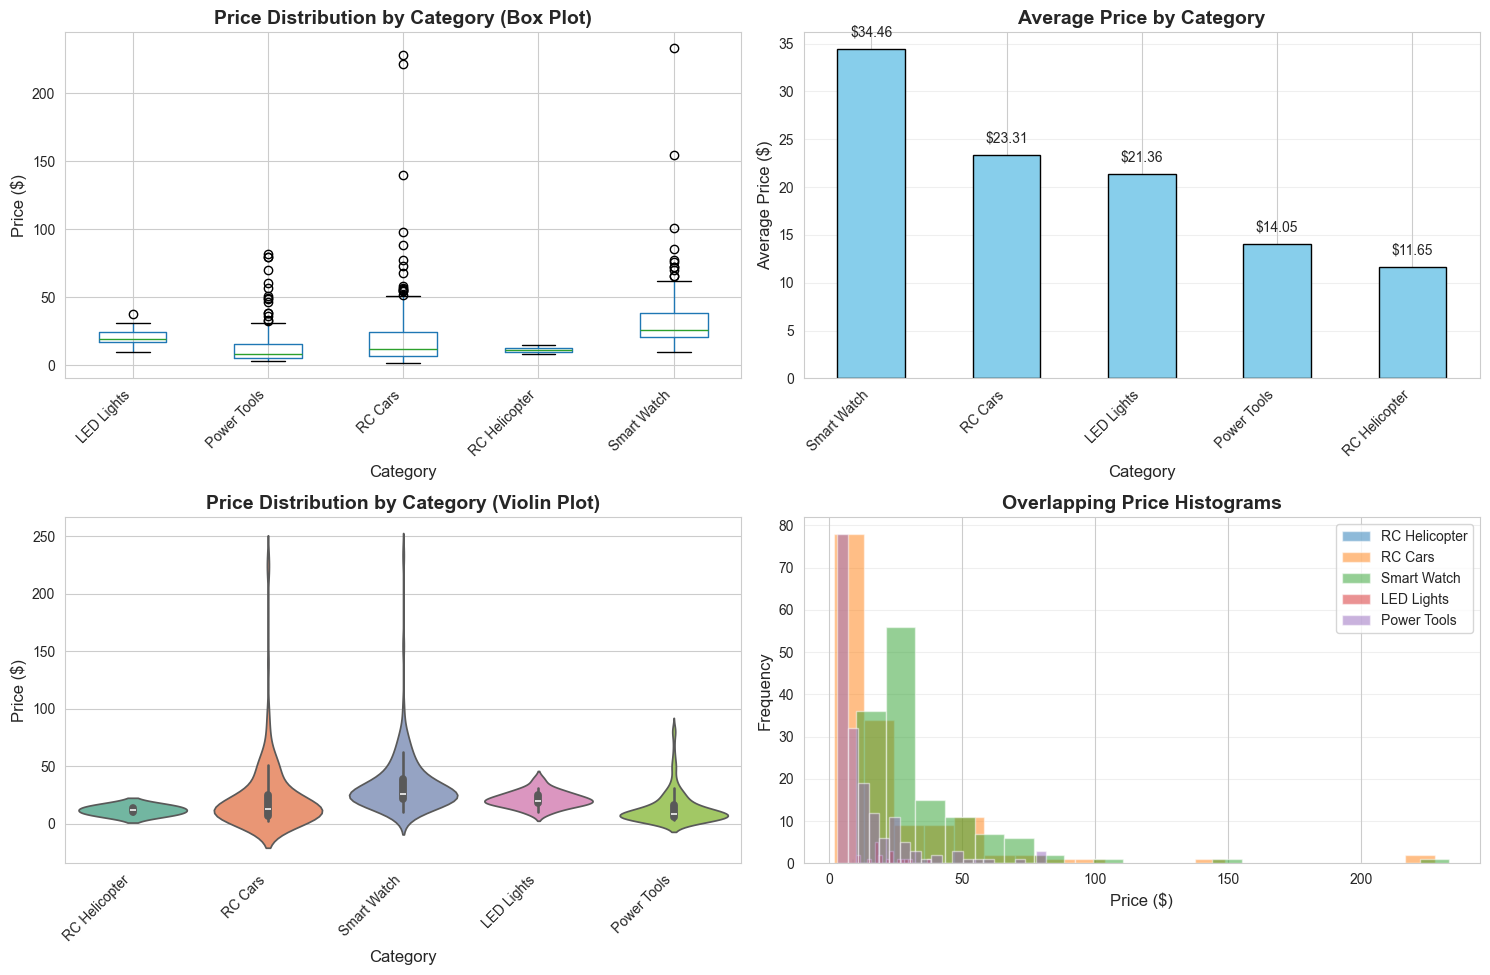


✓ ANALYSIS 1 COMPLETED!


In [19]:
# Analysis 1: Price Distribution per Category
print("="*70)
print("ANALYSIS 1: PRICE DISTRIBUTION PER CATEGORY")
print("="*70)

print("\n📊 What does this analysis show?")
print("   - Shows how prices are distributed across different categories")
print("   - Helps identify which categories are expensive or cheap")
print("   - Shows price range and variation within each category")

# Calculate statistics per category
print("\n" + "-"*70)
print("PRICE STATISTICS BY CATEGORY")
print("-"*70)

price_stats = df.groupby('category')['price_numeric'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Std Dev', 'std')
]).round(2)

print(price_stats)

# Find most and least expensive categories
print("\n" + "-"*70)
print("KEY INSIGHTS")
print("-"*70)

most_expensive = price_stats['Mean'].idxmax()
least_expensive = price_stats['Mean'].idxmin()
highest_price = price_stats['Max'].max()
lowest_price = price_stats['Min'].min()

print(f"\n💰 Most Expensive Category (by average):")
print(f"   {most_expensive}: ${price_stats.loc[most_expensive, 'Mean']:.2f}")

print(f"\n💵 Least Expensive Category (by average):")
print(f"   {least_expensive}: ${price_stats.loc[least_expensive, 'Mean']:.2f}")

print(f"\n📈 Highest Single Product Price:")
print(f"   ${highest_price:.2f}")

print(f"\n📉 Lowest Single Product Price:")
print(f"   ${lowest_price:.2f}")

# Price range analysis
print("\n" + "-"*70)
print("PRICE RANGE BY CATEGORY")
print("-"*70)

for category in df['category'].unique():
    cat_data = df[df['category'] == category]['price_numeric']
    price_range = cat_data.max() - cat_data.min()
    print(f"\n{category}:")
    print(f"   Range: ${cat_data.min():.2f} - ${cat_data.max():.2f}")
    print(f"   Spread: ${price_range:.2f}")

# Create visualizations
print("\n" + "-"*70)
print("CREATING VISUALIZATIONS...")
print("-"*70)

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Plot 1: Box plot - Price Distribution
plt.subplot(2, 2, 1)
df.boxplot(column='price_numeric', by='category', ax=plt.gca())
plt.title('Price Distribution by Category (Box Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.suptitle('')  # Remove default title

# Plot 2: Bar chart - Average Price
plt.subplot(2, 2, 2)
avg_prices = df.groupby('category')['price_numeric'].mean().sort_values(ascending=False)
avg_prices.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Price by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(avg_prices):
    plt.text(i, v + 1, f'${v:.2f}', ha='center', va='bottom', fontsize=10)

# Plot 3: Violin plot - Price Distribution
plt.subplot(2, 2, 3)
sns.violinplot(data=df, x='category', y='price_numeric', palette='Set2')
plt.title('Price Distribution by Category (Violin Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Plot 4: Histogram - Overall Price Distribution
plt.subplot(2, 2, 4)
for category in df['category'].unique():
    cat_prices = df[df['category'] == category]['price_numeric']
    plt.hist(cat_prices, alpha=0.5, label=category, bins=20)
plt.title('Overlapping Price Histograms', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('analysis1_price_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: analysis1_price_distribution.png")

plt.show()

print("\n" + "="*70)
print("✓ ANALYSIS 1 COMPLETED!")
print("="*70)

### Rating vs Price Correlation

ANALYSIS 2: RATING VS PRICE CORRELATION

📊 What does this analysis show?
   - Does higher price mean better rating?
   - Shows relationship between price and customer satisfaction
   - Helps identify if expensive products are worth the money

----------------------------------------------------------------------
CORRELATION ANALYSIS
----------------------------------------------------------------------

📈 Overall Correlation Coefficient: -0.0615
   Interpretation: Weak Negative Correlation
   → Higher prices tend to have lower ratings

----------------------------------------------------------------------
CORRELATION BY CATEGORY
----------------------------------------------------------------------

Category-wise Correlation:
   LED Lights: -0.1777
   Power Tools: 0.0657
   RC Cars: -0.0506
   RC Helicopter: nan
   Smart Watch: -0.0457

----------------------------------------------------------------------
STATISTICAL SIGNIFICANCE TEST
--------------------------------------------------

c:\Users\hm607\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\hm607\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\3323343443.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_corr = df.groupby('category').apply(
C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\3323343443.py:87: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of 

✓ Saved visualization: analysis2_rating_vs_price.png


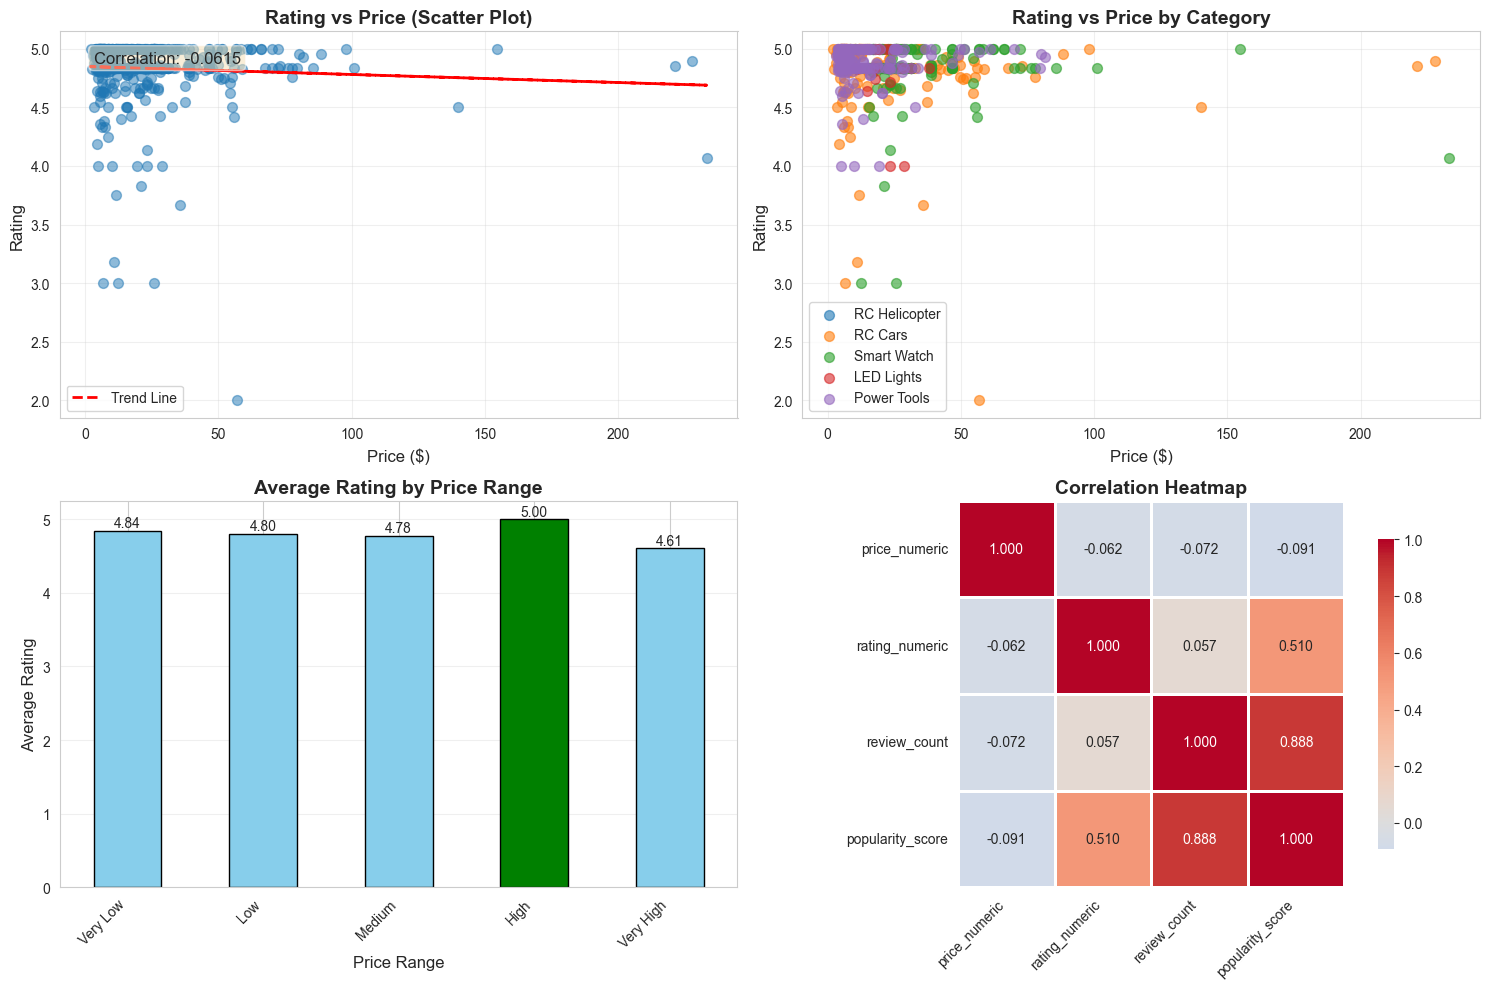


✓ ANALYSIS 2 COMPLETED!


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Load cleaned data
df = pd.read_csv('banggood_cleaned.csv')

# Analysis 2: Rating vs Price Correlation
print("="*70)
print("ANALYSIS 2: RATING VS PRICE CORRELATION")
print("="*70)

print("\n📊 What does this analysis show?")
print("   - Does higher price mean better rating?")
print("   - Shows relationship between price and customer satisfaction")
print("   - Helps identify if expensive products are worth the money")

# Calculate correlation
print("\n" + "-"*70)
print("CORRELATION ANALYSIS")
print("-"*70)

# Overall correlation
correlation = df['price_numeric'].corr(df['rating_numeric'])
print(f"\n📈 Overall Correlation Coefficient: {correlation:.4f}")

if correlation > 0.7:
    strength = "Strong Positive"
elif correlation > 0.3:
    strength = "Moderate Positive"
elif correlation > 0:
    strength = "Weak Positive"
elif correlation > -0.3:
    strength = "Weak Negative"
elif correlation > -0.7:
    strength = "Moderate Negative"
else:
    strength = "Strong Negative"

print(f"   Interpretation: {strength} Correlation")

if correlation > 0:
    print("   → Higher prices tend to have higher ratings")
else:
    print("   → Higher prices tend to have lower ratings")

# Correlation by category
print("\n" + "-"*70)
print("CORRELATION BY CATEGORY")
print("-"*70)

category_corr = df.groupby('category').apply(
    lambda x: x['price_numeric'].corr(x['rating_numeric'])
).round(4)

print("\nCategory-wise Correlation:")
for cat, corr in category_corr.items():
    print(f"   {cat}: {corr:.4f}")

# Statistical significance test
print("\n" + "-"*70)
print("STATISTICAL SIGNIFICANCE TEST")
print("-"*70)

# Pearson correlation test
pearson_corr, p_value = stats.pearsonr(df['price_numeric'], df['rating_numeric'])
print(f"\nPearson Correlation: {pearson_corr:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("✓ Result is STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print("✗ Result is NOT statistically significant (p >= 0.05)")

# Price range analysis
print("\n" + "-"*70)
print("RATING BY PRICE RANGE")
print("-"*70)

# Create price bins
df['price_range'] = pd.cut(df['price_numeric'], 
                           bins=5, 
                           labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

price_range_stats = df.groupby('price_range')['rating_numeric'].agg([
    ('Count', 'count'),
    ('Avg Rating', 'mean'),
    ('Min Rating', 'min'),
    ('Max Rating', 'max')
]).round(2)

print(price_range_stats)

# Find best rated price range
best_range = price_range_stats['Avg Rating'].idxmax()
print(f"\n⭐ Best Rated Price Range: {best_range}")
print(f"   Average Rating: {price_range_stats.loc[best_range, 'Avg Rating']:.2f}")

# Create visualizations
print("\n" + "-"*70)
print("CREATING VISUALIZATIONS...")
print("-"*70)

plt.figure(figsize=(15, 10))

# Plot 1: Scatter plot with regression line
plt.subplot(2, 2, 1)
plt.scatter(df['price_numeric'], df['rating_numeric'], alpha=0.5, s=50)

# Add regression line
z = np.polyfit(df['price_numeric'], df['rating_numeric'], 1)
p = np.poly1d(z)
plt.plot(df['price_numeric'], p(df['price_numeric']), "r--", linewidth=2, label='Trend Line')

plt.title('Rating vs Price (Scatter Plot)', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Category-wise scatter
plt.subplot(2, 2, 2)
for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    plt.scatter(cat_data['price_numeric'], cat_data['rating_numeric'], 
                label=category, alpha=0.6, s=50)

plt.title('Rating vs Price by Category', fontsize=14, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Plot 3: Bar chart - Average rating by price range
plt.subplot(2, 2, 3)
avg_rating_by_range = df.groupby('price_range')['rating_numeric'].mean()
colors = ['green' if x == avg_rating_by_range.max() else 'skyblue' for x in avg_rating_by_range]
avg_rating_by_range.plot(kind='bar', color=colors, edgecolor='black')
plt.title('Average Rating by Price Range', fontsize=14, fontweight='bold')
plt.xlabel('Price Range', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_rating_by_range):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontsize=10)

# Plot 4: Heatmap - Correlation matrix
plt.subplot(2, 2, 4)
corr_data = df[['price_numeric', 'rating_numeric', 'review_count', 'popularity_score']].corr()
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('analysis2_rating_vs_price.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: analysis2_rating_vs_price.png")

plt.show()

print("\n" + "="*70)
print("✓ ANALYSIS 2 COMPLETED!")
print("="*70)

### Top Reviewed Products

ANALYSIS 3: TOP REVIEWED PRODUCTS

📊 What does this analysis show?
   - Identifies the most popular products by review count
   - Shows which products customers engage with most
   - Helps understand customer interest patterns

----------------------------------------------------------------------
OVERALL REVIEW STATISTICS
----------------------------------------------------------------------

Total Products: 486
Total Reviews: 32,463
Average Reviews per Product: 66.80
Median Reviews per Product: 5
Products with 0 reviews: 116
Products with reviews: 370

----------------------------------------------------------------------
TOP 10 MOST REVIEWED PRODUCTS
----------------------------------------------------------------------

1. Geekcreit® AC 100-240V to DC 12V 5A 60W Switching Power Supp...
   Category: Power Tools
   Price: $5.43
   Rating: 4.94 ⭐
   Reviews: 3,297 💬

2. Geekcreit® XH-M229 Desktop Computer Chassis Power Supply Mod...
   Category: Power Tools
   Price: $5.12
   Rating: 

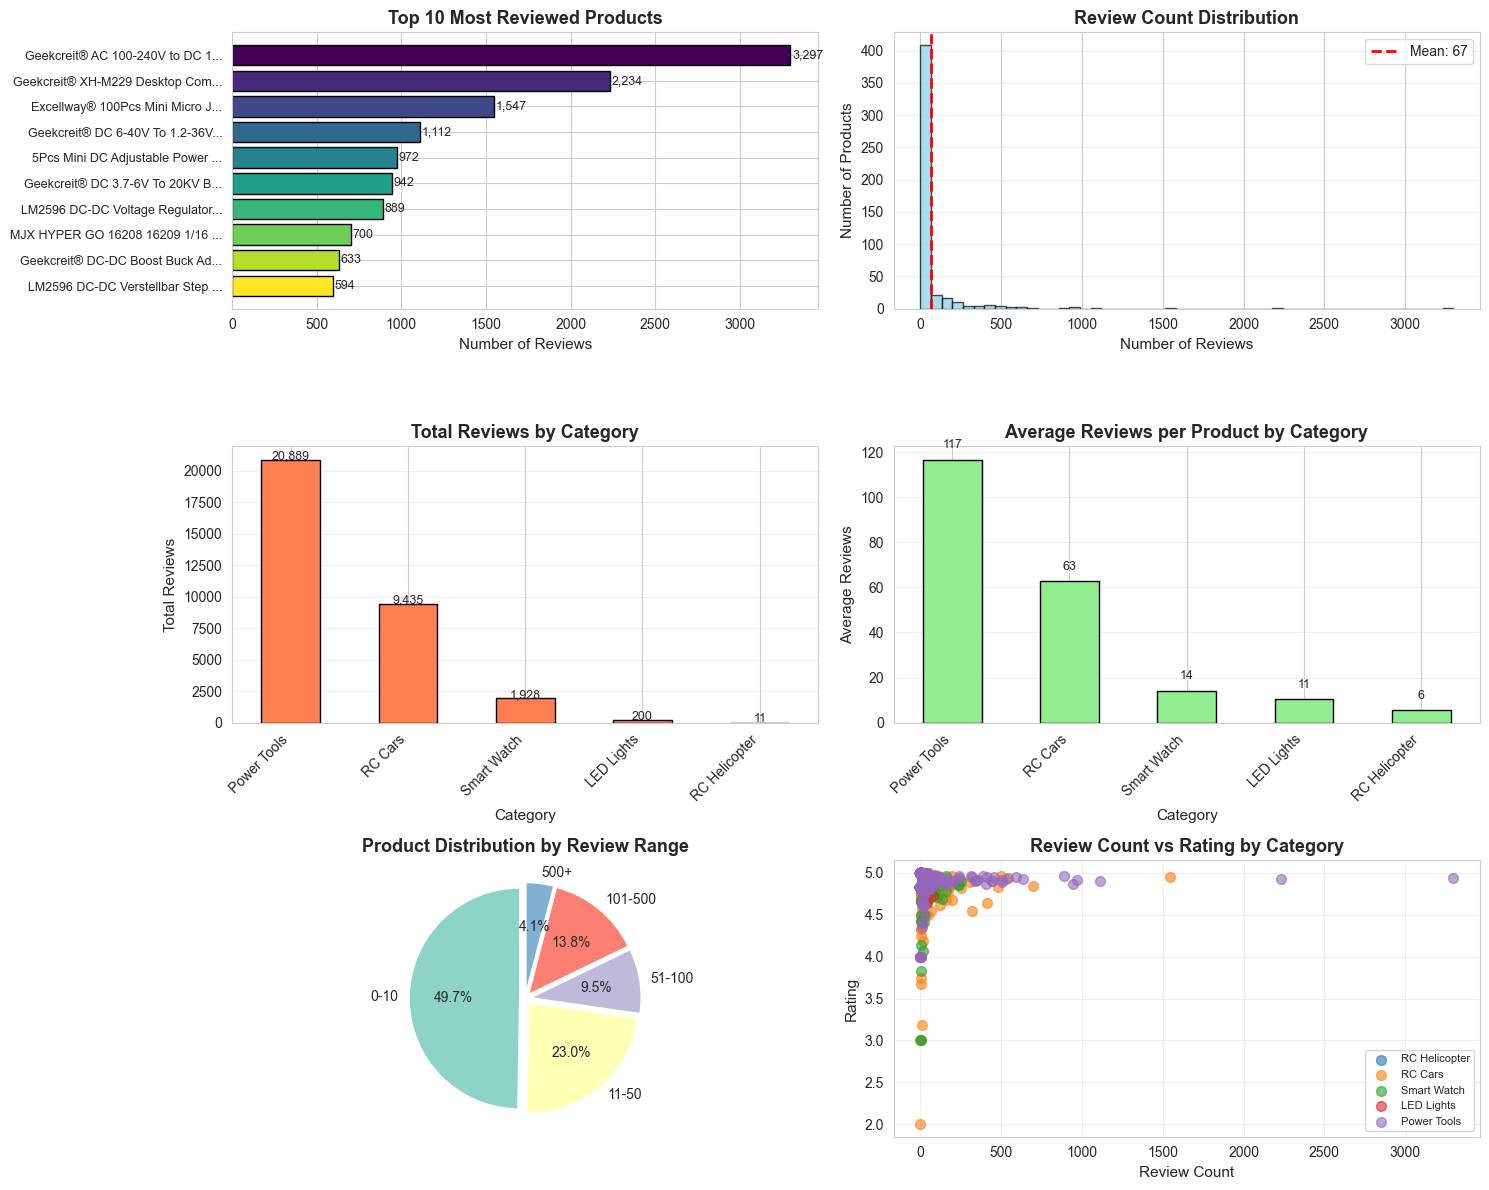


✓ ANALYSIS 3 COMPLETED!


In [24]:

import seaborn as sns



# Analysis 3: Top Reviewed Products
print("="*70)
print("ANALYSIS 3: TOP REVIEWED PRODUCTS")
print("="*70)

print("\n📊 What does this analysis show?")
print("   - Identifies the most popular products by review count")
print("   - Shows which products customers engage with most")
print("   - Helps understand customer interest patterns")

# Overall review statistics
print("\n" + "-"*70)
print("OVERALL REVIEW STATISTICS")
print("-"*70)

print(f"\nTotal Products: {len(df)}")
print(f"Total Reviews: {df['review_count'].sum():,}")
print(f"Average Reviews per Product: {df['review_count'].mean():.2f}")
print(f"Median Reviews per Product: {df['review_count'].median():.0f}")
print(f"Products with 0 reviews: {(df['review_count'] == 0).sum()}")
print(f"Products with reviews: {(df['review_count'] > 0).sum()}")

# Top 10 most reviewed products
print("\n" + "-"*70)
print("TOP 10 MOST REVIEWED PRODUCTS")
print("-"*70)

top_10 = df.nlargest(10, 'review_count')[['name', 'category', 'price_numeric', 
                                           'rating_numeric', 'review_count']]

for idx, row in enumerate(top_10.itertuples(), 1):
    print(f"\n{idx}. {row.name[:60]}...")
    print(f"   Category: {row.category}")
    print(f"   Price: ${row.price_numeric:.2f}")
    print(f"   Rating: {row.rating_numeric:.2f} ⭐")
    print(f"   Reviews: {row.review_count:,} 💬")

# Top reviewed by category
print("\n" + "-"*70)
print("TOP REVIEWED PRODUCT IN EACH CATEGORY")
print("-"*70)

for category in df['category'].unique():
    cat_top = df[df['category'] == category].nlargest(1, 'review_count').iloc[0]
    print(f"\n{category}:")
    print(f"   Product: {cat_top['name'][:50]}...")
    print(f"   Reviews: {cat_top['review_count']:,}")
    print(f"   Rating: {cat_top['rating_numeric']:.2f}")
    print(f"   Price: ${cat_top['price_numeric']:.2f}")

# Review distribution analysis
print("\n" + "-"*70)
print("REVIEW COUNT DISTRIBUTION")
print("-"*70)

# Create review bins
df['review_category'] = pd.cut(df['review_count'], 
                               bins=[0, 10, 50, 100, 500, float('inf')],
                               labels=['0-10', '11-50', '51-100', '101-500', '500+'])

review_dist = df['review_category'].value_counts().sort_index()
print("\nProducts by Review Count Range:")
for category, count in review_dist.items():
    percentage = (count / len(df)) * 100
    print(f"   {category} reviews: {count} products ({percentage:.1f}%)")

# Category-wise review statistics
print("\n" + "-"*70)
print("REVIEW STATISTICS BY CATEGORY")
print("-"*70)

category_stats = df.groupby('category')['review_count'].agg([
    ('Total Products', 'count'),
    ('Total Reviews', 'sum'),
    ('Avg Reviews', 'mean'),
    ('Max Reviews', 'max')
]).round(2)

print(category_stats)

# Most engaged category
most_engaged = category_stats['Total Reviews'].idxmax()
print(f"\n🏆 Most Engaged Category: {most_engaged}")
print(f"   Total Reviews: {category_stats.loc[most_engaged, 'Total Reviews']:,.0f}")

# Create visualizations
print("\n" + "-"*70)
print("CREATING VISUALIZATIONS...")
print("-"*70)

plt.figure(figsize=(15, 12))

# Plot 1: Top 10 most reviewed products (horizontal bar)
plt.subplot(3, 2, 1)
top_10_plot = df.nlargest(10, 'review_count')
y_pos = np.arange(len(top_10_plot))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10_plot)))

plt.barh(y_pos, top_10_plot['review_count'], color=colors, edgecolor='black')
plt.yticks(y_pos, [name[:30] + '...' for name in top_10_plot['name']], fontsize=9)
plt.xlabel('Number of Reviews', fontsize=11)
plt.title('Top 10 Most Reviewed Products', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(top_10_plot['review_count']):
    plt.text(v + 10, i, f'{v:,}', va='center', fontsize=9)

# Plot 2: Review distribution histogram
plt.subplot(3, 2, 2)
plt.hist(df['review_count'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Reviews', fontsize=11)
plt.ylabel('Number of Products', fontsize=11)
plt.title('Review Count Distribution', fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.axvline(df['review_count'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["review_count"].mean():.0f}')
plt.legend()

# Plot 3: Reviews by category (bar chart)
plt.subplot(3, 2, 3)
reviews_by_cat = df.groupby('category')['review_count'].sum().sort_values(ascending=False)
reviews_by_cat.plot(kind='bar', color='coral', edgecolor='black')
plt.xlabel('Category', fontsize=11)
plt.ylabel('Total Reviews', fontsize=11)
plt.title('Total Reviews by Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(reviews_by_cat):
    plt.text(i, v + 50, f'{v:,.0f}', ha='center', fontsize=9)

# Plot 4: Average reviews by category
plt.subplot(3, 2, 4)
avg_reviews_by_cat = df.groupby('category')['review_count'].mean().sort_values(ascending=False)
avg_reviews_by_cat.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Category', fontsize=11)
plt.ylabel('Average Reviews', fontsize=11)
plt.title('Average Reviews per Product by Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_reviews_by_cat):
    plt.text(i, v + 5, f'{v:.0f}', ha='center', fontsize=9)

# Plot 5: Review category distribution (pie chart)
plt.subplot(3, 2, 5)
review_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                 colors=plt.cm.Set3.colors, explode=[0.05]*len(review_dist))
plt.ylabel('')
plt.title('Product Distribution by Review Range', fontsize=13, fontweight='bold')

# Plot 6: Reviews vs Rating scatter (colored by category)
plt.subplot(3, 2, 6)
for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    plt.scatter(cat_data['review_count'], cat_data['rating_numeric'], 
                label=category, alpha=0.6, s=50)

plt.xlabel('Review Count', fontsize=11)
plt.ylabel('Rating', fontsize=11)
plt.title('Review Count vs Rating by Category', fontsize=13, fontweight='bold')
plt.legend(fontsize=8)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('analysis3_top_reviewed.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: analysis3_top_reviewed.png")

plt.show()

print("\n" + "="*70)
print("✓ ANALYSIS 3 COMPLETED!")
print("="*70)

###  Best Value Metric per Category

ANALYSIS 4: BEST VALUE METRIC PER CATEGORY

📊 What does this analysis show?
   - Identifies products offering best value for money
   - Combines price and quality (rating) to find bargains
   - Helps customers find high-quality affordable products

----------------------------------------------------------------------
CALCULATING VALUE SCORE
----------------------------------------------------------------------

💡 Value Score Formula:
   Value Score = (Rating / Max_Rating) × 100 ÷ (Price / Max_Price)
   → Higher score = Better value (high quality + low price)

✓ Value score calculated (0-100 scale)
   60% weight on rating, 40% weight on inverse price

----------------------------------------------------------------------
TOP 10 BEST VALUE PRODUCTS (OVERALL)
----------------------------------------------------------------------

1. UDIRC UDI021 Eachine EBT04 RC Boat Parts Tail Rudder As...
   Category: RC Cars
   Price: $2.01 💵
   Rating: 5.00 ⭐
   Reviews: 4 💬
   Value Score: 100.00 🏆


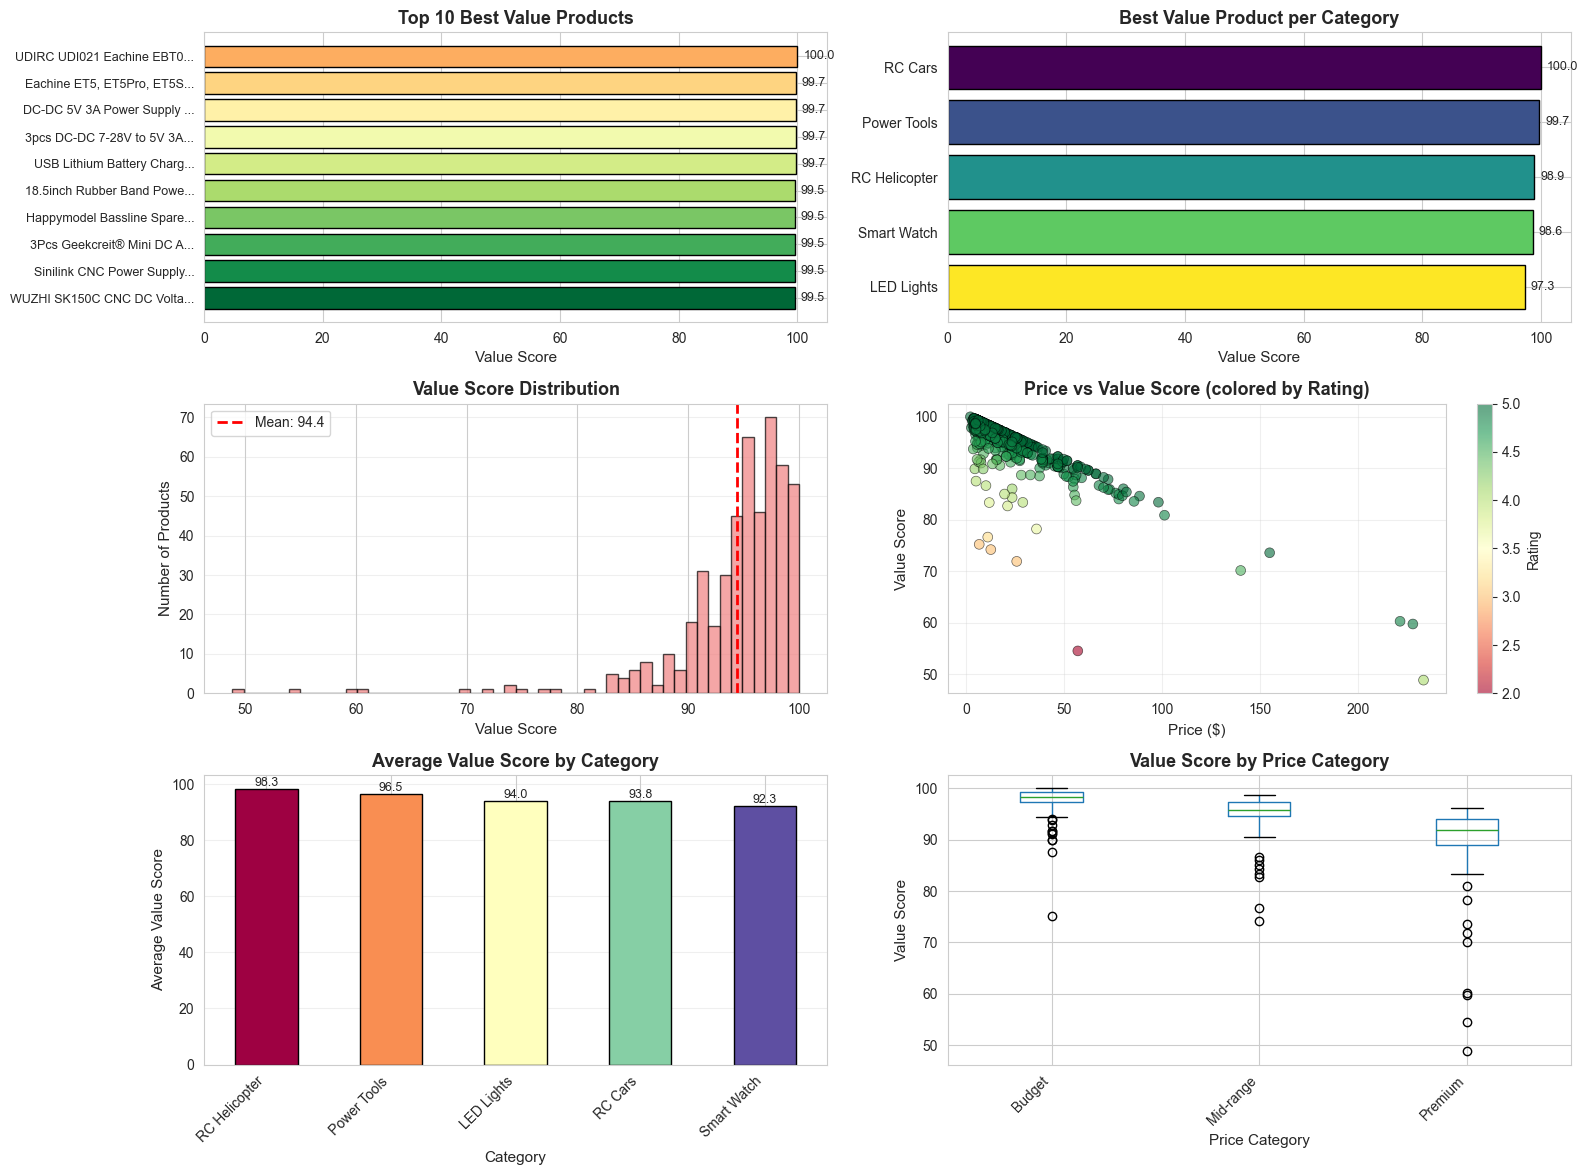

✓ Saved best value products to: best_value_products.csv

✓ ANALYSIS 4 COMPLETED!


In [25]:

# Analysis 4: Best Value Metric per Category
print("="*70)
print("ANALYSIS 4: BEST VALUE METRIC PER CATEGORY")
print("="*70)

print("\n📊 What does this analysis show?")
print("   - Identifies products offering best value for money")
print("   - Combines price and quality (rating) to find bargains")
print("   - Helps customers find high-quality affordable products")

# Calculate Value Score
print("\n" + "-"*70)
print("CALCULATING VALUE SCORE")
print("-"*70)

print("\n💡 Value Score Formula:")
print("   Value Score = (Rating / Max_Rating) × 100 ÷ (Price / Max_Price)")
print("   → Higher score = Better value (high quality + low price)")

# Normalize rating (0-1 scale)
max_rating = df['rating_numeric'].max()
normalized_rating = df['rating_numeric'] / max_rating

# Normalize price inversely (lower price = higher score)
max_price = df['price_numeric'].max()
min_price = df['price_numeric'].min()
normalized_price_inverse = 1 - ((df['price_numeric'] - min_price) / (max_price - min_price))

# Calculate value score
df['value_score'] = (normalized_rating * 0.6 + normalized_price_inverse * 0.4) * 100

print(f"\n✓ Value score calculated (0-100 scale)")
print(f"   60% weight on rating, 40% weight on inverse price")

# Overall best value products
print("\n" + "-"*70)
print("TOP 10 BEST VALUE PRODUCTS (OVERALL)")
print("-"*70)

top_value = df.nlargest(10, 'value_score')[['name', 'category', 'price_numeric', 
                                             'rating_numeric', 'review_count', 'value_score']]

for idx, row in enumerate(top_value.itertuples(), 1):
    print(f"\n{idx}. {row.name[:55]}...")
    print(f"   Category: {row.category}")
    print(f"   Price: ${row.price_numeric:.2f} 💵")
    print(f"   Rating: {row.rating_numeric:.2f} ⭐")
    print(f"   Reviews: {row.review_count:,} 💬")
    print(f"   Value Score: {row.value_score:.2f} 🏆")

# Best value by category
print("\n" + "-"*70)
print("BEST VALUE PRODUCT IN EACH CATEGORY")
print("-"*70)

best_value_by_category = pd.DataFrame()

for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    best_in_cat = cat_data.nlargest(1, 'value_score').iloc[0]
    
    print(f"\n🏆 {category}:")
    print(f"   Product: {best_in_cat['name'][:50]}...")
    print(f"   Price: ${best_in_cat['price_numeric']:.2f}")
    print(f"   Rating: {best_in_cat['rating_numeric']:.2f}")
    print(f"   Reviews: {best_in_cat['review_count']:,}")
    print(f"   Value Score: {best_in_cat['value_score']:.2f}")
    
    # Store for visualization
    temp_df = pd.DataFrame([{
        'Category': category,
        'Product': best_in_cat['name'][:30] + '...',
        'Value_Score': best_in_cat['value_score'],
        'Price': best_in_cat['price_numeric'],
        'Rating': best_in_cat['rating_numeric']
    }])
    best_value_by_category = pd.concat([best_value_by_category, temp_df], ignore_index=True)

# Value score statistics
print("\n" + "-"*70)
print("VALUE SCORE STATISTICS")
print("-"*70)

value_stats = df.groupby('category')['value_score'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Max', 'max'),
    ('Min', 'min')
]).round(2)

print(value_stats)

# Price vs Value analysis
print("\n" + "-"*70)
print("PRICE CATEGORY VS VALUE ANALYSIS")
print("-"*70)

price_value = df.groupby('price_category')['value_score'].agg([
    ('Products', 'count'),
    ('Avg Value Score', 'mean')
]).round(2)

print(price_value)

print("\n💡 Insight:")
best_price_cat = price_value['Avg Value Score'].idxmax()
print(f"   {best_price_cat} products offer the best average value!")

# Create visualizations
print("\n" + "-"*70)
print("CREATING VISUALIZATIONS...")
print("-"*70)

plt.figure(figsize=(16, 12))

# Plot 1: Best value products (horizontal bar)
plt.subplot(3, 2, 1)
top_10_value = df.nlargest(10, 'value_score')
y_pos = np.arange(len(top_10_value))
colors = plt.cm.RdYlGn(np.linspace(0.3, 1, len(top_10_value)))

plt.barh(y_pos, top_10_value['value_score'], color=colors, edgecolor='black')
plt.yticks(y_pos, [name[:25] + '...' for name in top_10_value['name']], fontsize=9)
plt.xlabel('Value Score', fontsize=11)
plt.title('Top 10 Best Value Products', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(top_10_value['value_score']):
    plt.text(v + 1, i, f'{v:.1f}', va='center', fontsize=9)

# Plot 2: Best value by category
plt.subplot(3, 2, 2)
best_value_by_category.sort_values('Value_Score', ascending=False, inplace=True)
y_pos = np.arange(len(best_value_by_category))
colors = plt.cm.viridis(np.linspace(0, 1, len(best_value_by_category)))

plt.barh(y_pos, best_value_by_category['Value_Score'], color=colors, edgecolor='black')
plt.yticks(y_pos, best_value_by_category['Category'], fontsize=10)
plt.xlabel('Value Score', fontsize=11)
plt.title('Best Value Product per Category', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for i, v in enumerate(best_value_by_category['Value_Score']):
    plt.text(v + 1, i, f'{v:.1f}', va='center', fontsize=9)

# Plot 3: Value score distribution
plt.subplot(3, 2, 3)
plt.hist(df['value_score'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
plt.xlabel('Value Score', fontsize=11)
plt.ylabel('Number of Products', fontsize=11)
plt.title('Value Score Distribution', fontsize=13, fontweight='bold')
plt.axvline(df['value_score'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["value_score"].mean():.1f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot 4: Price vs Value Score scatter
plt.subplot(3, 2, 4)
scatter = plt.scatter(df['price_numeric'], df['value_score'], 
                     c=df['rating_numeric'], cmap='RdYlGn', 
                     s=50, alpha=0.6, edgecolor='black', linewidth=0.5)
plt.colorbar(scatter, label='Rating')
plt.xlabel('Price ($)', fontsize=11)
plt.ylabel('Value Score', fontsize=11)
plt.title('Price vs Value Score (colored by Rating)', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)

# Plot 5: Average value score by category
plt.subplot(3, 2, 5)
avg_value_by_cat = df.groupby('category')['value_score'].mean().sort_values(ascending=False)
colors = plt.cm.Spectral(np.linspace(0, 1, len(avg_value_by_cat)))
avg_value_by_cat.plot(kind='bar', color=colors, edgecolor='black')
plt.xlabel('Category', fontsize=11)
plt.ylabel('Average Value Score', fontsize=11)
plt.title('Average Value Score by Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_value_by_cat):
    plt.text(i, v + 1, f'{v:.1f}', ha='center', fontsize=9)

# Plot 6: Price category vs Value score
plt.subplot(3, 2, 6)
df.boxplot(column='value_score', by='price_category', ax=plt.gca())
plt.title('Value Score by Price Category', fontsize=13, fontweight='bold')
plt.suptitle('')
plt.xlabel('Price Category', fontsize=11)
plt.ylabel('Value Score', fontsize=11)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('analysis4_best_value.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: analysis4_best_value.png")

plt.show()

# Export best value products
best_value_export = df.nlargest(20, 'value_score')[['name', 'category', 'price_numeric', 
                                                     'rating_numeric', 'review_count', 'value_score']]
best_value_export.to_csv('best_value_products.csv', index=False)
print("✓ Saved best value products to: best_value_products.csv")

print("\n" + "="*70)
print("✓ ANALYSIS 4 COMPLETED!")
print("="*70)

### Product Rating Quality Analysis

ANALYSIS 5: PRODUCT RATING QUALITY ANALYSIS

📊 What does this analysis show?
   - Distribution of product ratings across categories
   - Identifies excellent vs poor quality products
   - Shows customer satisfaction patterns

----------------------------------------------------------------------
RATING QUALITY CATEGORIES
----------------------------------------------------------------------

📊 Rating Categories:
   Excellent: ≥ 4.5 ⭐⭐⭐⭐⭐
   Good:      4.0 - 4.49 ⭐⭐⭐⭐
   Average:   3.5 - 3.99 ⭐⭐⭐
   Poor:      < 3.5 ⭐⭐

----------------------------------------------------------------------
OVERALL RATING QUALITY DISTRIBUTION
----------------------------------------------------------------------

Product Count by Rating Quality:
   Excellent: 461 products (94.9%)
   Good: 17 products (3.5%)
   Poor: 5 products (1.0%)
   Average: 3 products (0.6%)

----------------------------------------------------------------------
RATING STATISTICS
-----------------------------------------------------

C:\Users\hm607\AppData\Local\Temp\ipykernel_7932\929142539.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='price_category', y='rating_numeric',


✓ Saved visualization: analysis5_rating_quality.png


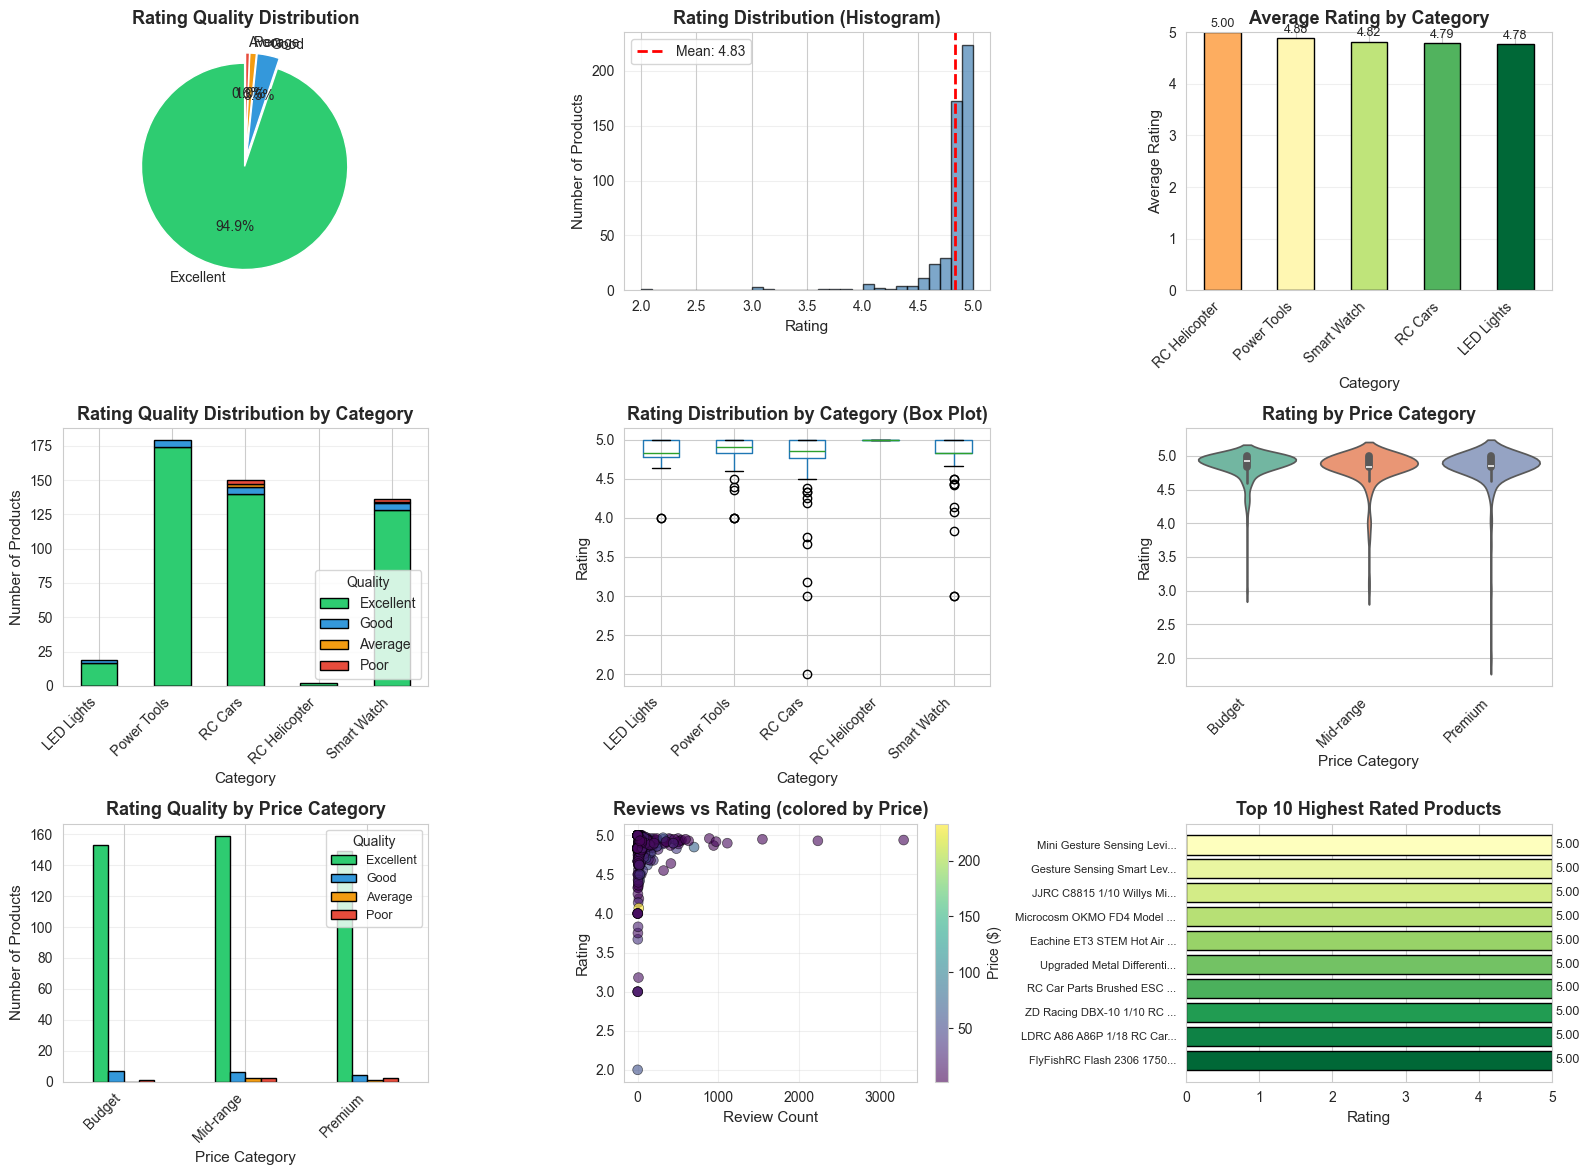


✓ ANALYSIS 5 COMPLETED!


In [26]:
# Analysis 5: Product Rating Quality Analysis
print("="*70)
print("ANALYSIS 5: PRODUCT RATING QUALITY ANALYSIS")
print("="*70)

print("\n📊 What does this analysis show?")
print("   - Distribution of product ratings across categories")
print("   - Identifies excellent vs poor quality products")
print("   - Shows customer satisfaction patterns")

# Create rating categories
print("\n" + "-"*70)
print("RATING QUALITY CATEGORIES")
print("-"*70)

def categorize_rating(rating):
    """Categorize ratings into quality levels"""
    if pd.isna(rating):
        return 'Unrated'
    elif rating >= 4.5:
        return 'Excellent'
    elif rating >= 4.0:
        return 'Good'
    elif rating >= 3.5:
        return 'Average'
    else:
        return 'Poor'

df['rating_quality'] = df['rating_numeric'].apply(categorize_rating)

print("\n📊 Rating Categories:")
print("   Excellent: ≥ 4.5 ⭐⭐⭐⭐⭐")
print("   Good:      4.0 - 4.49 ⭐⭐⭐⭐")
print("   Average:   3.5 - 3.99 ⭐⭐⭐")
print("   Poor:      < 3.5 ⭐⭐")

# Overall rating distribution
print("\n" + "-"*70)
print("OVERALL RATING QUALITY DISTRIBUTION")
print("-"*70)

rating_dist = df['rating_quality'].value_counts()
print("\nProduct Count by Rating Quality:")
for quality, count in rating_dist.items():
    percentage = (count / len(df)) * 100
    print(f"   {quality}: {count} products ({percentage:.1f}%)")

# Rating statistics
print("\n" + "-"*70)
print("RATING STATISTICS")
print("-"*70)

print(f"\nMean Rating: {df['rating_numeric'].mean():.2f}")
print(f"Median Rating: {df['rating_numeric'].median():.2f}")
print(f"Mode Rating: {df['rating_numeric'].mode().values[0]:.2f}")
print(f"Std Deviation: {df['rating_numeric'].std():.2f}")
print(f"Min Rating: {df['rating_numeric'].min():.2f}")
print(f"Max Rating: {df['rating_numeric'].max():.2f}")

# Rating by category
print("\n" + "-"*70)
print("RATING QUALITY BY CATEGORY")
print("-"*70)

rating_by_cat = pd.crosstab(df['category'], df['rating_quality'], normalize='index') * 100
print("\nPercentage Distribution:")
print(rating_by_cat.round(1))

# Best rated category
print("\n" + "-"*70)
print("CATEGORY RATING ANALYSIS")
print("-"*70)

category_ratings = df.groupby('category')['rating_numeric'].agg([
    ('Count', 'count'),
    ('Mean Rating', 'mean'),
    ('Median Rating', 'median'),
    ('Min Rating', 'min'),
    ('Max Rating', 'max')
]).round(2)

print(category_ratings)

best_category = category_ratings['Mean Rating'].idxmax()
worst_category = category_ratings['Mean Rating'].idxmin()

print(f"\n🏆 Best Rated Category: {best_category}")
print(f"   Average Rating: {category_ratings.loc[best_category, 'Mean Rating']:.2f}")

print(f"\n📉 Lowest Rated Category: {worst_category}")
print(f"   Average Rating: {category_ratings.loc[worst_category, 'Mean Rating']:.2f}")

# Top rated products
print("\n" + "-"*70)
print("TOP 10 HIGHEST RATED PRODUCTS")
print("-"*70)

top_rated = df.nlargest(10, 'rating_numeric')[['name', 'category', 'rating_numeric', 
                                                'review_count', 'price_numeric']]

for idx, row in enumerate(top_rated.itertuples(), 1):
    print(f"\n{idx}. {row.name[:55]}...")
    print(f"   Category: {row.category}")
    print(f"   Rating: {row.rating_numeric:.2f} ⭐")
    print(f"   Reviews: {row.review_count:,} 💬")
    print(f"   Price: ${row.price_numeric:.2f}")

# Rating vs Price analysis
print("\n" + "-"*70)
print("RATING QUALITY BY PRICE CATEGORY")
print("-"*70)

rating_price = pd.crosstab(df['price_category'], df['rating_quality'], normalize='index') * 100
print("\nPercentage Distribution:")
print(rating_price.round(1))

# Products needing attention (low ratings)
print("\n" + "-"*70)
print("PRODUCTS NEEDING ATTENTION (Poor Ratings)")
print("-"*70)

poor_products = df[df['rating_quality'] == 'Poor'].nsmallest(5, 'rating_numeric')[
    ['name', 'category', 'rating_numeric', 'review_count', 'price_numeric']
]

if len(poor_products) > 0:
    print(f"\nFound {len(df[df['rating_quality'] == 'Poor'])} products with poor ratings")
    print("\nBottom 5:")
    for idx, row in enumerate(poor_products.itertuples(), 1):
        print(f"\n{idx}. {row.name[:50]}...")
        print(f"   Category: {row.category}")
        print(f"   Rating: {row.rating_numeric:.2f}")
        print(f"   Reviews: {row.review_count:,}")
        print(f"   Price: ${row.price_numeric:.2f}")
else:
    print("\n✓ No products with poor ratings found!")

# Create visualizations
print("\n" + "-"*70)
print("CREATING VISUALIZATIONS...")
print("-"*70)

plt.figure(figsize=(16, 12))

# Plot 1: Rating quality distribution (pie chart)
plt.subplot(3, 3, 1)
colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
rating_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, 
                 colors=colors_pie, explode=[0.05]*len(rating_dist))
plt.ylabel('')
plt.title('Rating Quality Distribution', fontsize=13, fontweight='bold')

# Plot 2: Rating distribution histogram
plt.subplot(3, 3, 2)
plt.hist(df['rating_numeric'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Rating', fontsize=11)
plt.ylabel('Number of Products', fontsize=11)
plt.title('Rating Distribution (Histogram)', fontsize=13, fontweight='bold')
plt.axvline(df['rating_numeric'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["rating_numeric"].mean():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot 3: Average rating by category
plt.subplot(3, 3, 3)
avg_rating_cat = df.groupby('category')['rating_numeric'].mean().sort_values(ascending=False)
colors_bar = plt.cm.RdYlGn(np.linspace(0.3, 1, len(avg_rating_cat)))
avg_rating_cat.plot(kind='bar', color=colors_bar, edgecolor='black')
plt.xlabel('Category', fontsize=11)
plt.ylabel('Average Rating', fontsize=11)
plt.title('Average Rating by Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 5)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_rating_cat):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=9)

# Plot 4: Rating quality stacked bar by category
plt.subplot(3, 3, 4)
rating_by_cat_counts = pd.crosstab(df['category'], df['rating_quality'])
rating_by_cat_counts[['Excellent', 'Good', 'Average', 'Poor']].plot(
    kind='bar', stacked=True, ax=plt.gca(),
    color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c'],
    edgecolor='black'
)
plt.xlabel('Category', fontsize=11)
plt.ylabel('Number of Products', fontsize=11)
plt.title('Rating Quality Distribution by Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Quality')
plt.grid(axis='y', alpha=0.3)

# Plot 5: Box plot - Ratings by category
plt.subplot(3, 3, 5)
df.boxplot(column='rating_numeric', by='category', ax=plt.gca())
plt.title('Rating Distribution by Category (Box Plot)', fontsize=13, fontweight='bold')
plt.suptitle('')
plt.xlabel('Category', fontsize=11)
plt.ylabel('Rating', fontsize=11)
plt.xticks(rotation=45, ha='right')

# Plot 6: Violin plot - Ratings by price category
plt.subplot(3, 3, 6)
sns.violinplot(data=df, x='price_category', y='rating_numeric', 
               palette='Set2', order=['Budget', 'Mid-range', 'Premium'])
plt.xlabel('Price Category', fontsize=11)
plt.ylabel('Rating', fontsize=11)
plt.title('Rating by Price Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')

# Plot 7: Rating quality by price category
plt.subplot(3, 3, 7)
rating_price_counts = pd.crosstab(df['price_category'], df['rating_quality'])
rating_price_counts.loc[['Budget', 'Mid-range', 'Premium'], 
                        ['Excellent', 'Good', 'Average', 'Poor']].plot(
    kind='bar', ax=plt.gca(),
    color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c'],
    edgecolor='black'
)
plt.xlabel('Price Category', fontsize=11)
plt.ylabel('Number of Products', fontsize=11)
plt.title('Rating Quality by Price Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Quality', fontsize=9)
plt.grid(axis='y', alpha=0.3)

# Plot 8: Rating vs Review Count scatter
plt.subplot(3, 3, 8)
scatter = plt.scatter(df['review_count'], df['rating_numeric'], 
                     c=df['price_numeric'], cmap='viridis', 
                     s=50, alpha=0.6, edgecolor='black', linewidth=0.5)
plt.colorbar(scatter, label='Price ($)')
plt.xlabel('Review Count', fontsize=11)
plt.ylabel('Rating', fontsize=11)
plt.title('Reviews vs Rating (colored by Price)', fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)

# Plot 9: Top 10 highest rated products
plt.subplot(3, 3, 9)
top_10_rated = df.nlargest(10, 'rating_numeric')
y_pos = np.arange(len(top_10_rated))
colors = plt.cm.RdYlGn(np.linspace(0.5, 1, len(top_10_rated)))

plt.barh(y_pos, top_10_rated['rating_numeric'], color=colors, edgecolor='black')
plt.yticks(y_pos, [name[:25] + '...' for name in top_10_rated['name']], fontsize=8)
plt.xlabel('Rating', fontsize=11)
plt.title('Top 10 Highest Rated Products', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.xlim(0, 5)

# Add value labels
for i, v in enumerate(top_10_rated['rating_numeric']):
    plt.text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('analysis5_rating_quality.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: analysis5_rating_quality.png")

plt.show()

print("\n" + "="*70)
print("✓ ANALYSIS 5 COMPLETED!")
print("="*70)

# Load Data into SQL Server

### import and make connection to sql

In [44]:
import pyodbc

# Your SQL Server name (from SSMS login screen)
server = r"HAMZA-MUGHAL"
database = "bangood"

conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    'Trusted_Connection=yes;'
)

print("Connected successfully!")


Connected successfully!


In [29]:
df.head(5)

,name,url,price,rating,reviews,product_id,category,page,price_numeric,rating_numeric,review_count,price_category,popularity_score,currency,review_category,value_score,rating_quality
0,Mini Gesture Sensing Levitation Flying Led Lig...,https://www.banggood.com/Mini-Gesture-Sensing-...,£14.76,5.00,5,1978021,RC Helicopter,1,14.76,5.00,5,Mid-range,40.090992,£,0-10,97.794213,Excellent
1,Gesture Sensing Smart Levitation Led Light Alt...,https://www.banggood.com/Gesture-Sensing-Smart...,£8.54,5.00,6,1978025,RC Helicopter,1,8.54,5.00,6,Budget,40.109190,£,0-10,98.870291,Excellent
2,JIABAILE 4301/02/03/04 RTR 1/43 2.4G 4WD Drift...,https://www.banggood.com/JIABAILE-4301-or-02-o...,£18.34,4.82,254,2017095,RC Cars,1,18.34,4.82,254,Mid-range,43.182384,£,101-500,95.014863,Excellent
3,MJX HYPER GO 16208 16209 1/16 Brushless High S...,https://www.banggood.com/MJX-HYPER-GO-16208-16...,£73.07,4.85,700,1967165,RC Cars,1,73.07,4.85,700,Premium,51.538854,£,500+,85.906414,Excellent
4,Orlandoo Hunter OH32X02 1/32 RWD Mini Truck RC...,https://www.banggood.com/Orlandoo-Hunter-OH32X...,£58.77,4.83,42,1989380,RC Cars,1,58.77,4.83,42,Premium,39.404331,£,11-50,88.140356,Excellent


### create table in db

In [40]:

cursor = conn.cursor()

# --- SQL CREATE TABLE ---
create_table_sql = """
IF NOT EXISTS (SELECT * FROM sys.tables WHERE name = 'banggood')
BEGIN
    CREATE TABLE banggood (
        id INT IDENTITY(1,1) PRIMARY KEY,
        name NVARCHAR(MAX),
        url NVARCHAR(MAX),
        price NVARCHAR(50),
        rating FLOAT,
        reviews INT,
        product_id INT,
        category NVARCHAR(200),
        page INT,
        price_numeric FLOAT,
        rating_numeric FLOAT,
        review_count INT,
        price_category NVARCHAR(100),
        popularity_score FLOAT,
        currency NVARCHAR(10)
    );
END
"""

# Execute and commit
cursor.execute(create_table_sql)
conn.commit()

print("Table 'banggood' created successfully!")

# Close connection
cursor.close()
conn.close()


Table 'banggood' created successfully!


In [35]:
print(df.columns)


Index(['name', 'url', 'price', 'rating', 'reviews', 'product_id', 'category',
       'page', 'price_numeric', 'rating_numeric', 'review_count',
       'price_category', 'popularity_score', 'currency'],
      dtype='object')


### upload data in db 

In [49]:


# Convert all values to string
df_str = df.fillna('').astype(str)

server = r"HAMZA-MUGHAL"
database = "bangood"

conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()
cursor.fast_executemany = True  # speeds up inserts

# Insert DataFrame
data_to_insert = df_str[[
    'name', 'url', 'price', 'rating', 'reviews', 'product_id', 'category', 'page', 
    'price_numeric', 'rating_numeric', 'review_count', 'price_category', 
    'popularity_score', 'currency'
]].values.tolist()

insert_sql = """
    INSERT INTO banggood (
        name, url, price, rating, reviews, product_id, category, page, 
        price_numeric, rating_numeric, review_count, price_category, 
        popularity_score, currency
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
"""

cursor.executemany(insert_sql, data_to_insert)
conn.commit()
cursor.close()
conn.close()

print("Data uploaded successfully!")


Data uploaded successfully!
